In [115]:
import numpy as np
import datetime
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse
import pydot
import pylab as py
import sys
import pygraphviz
from sklearn import preprocessing

In [2]:
data = pd.read_csv('/Users/klaudiamur/Dropbox/CommNet/data SU/data.csv')

In [3]:
data = data[~data['user'].isnull()]

data['ts'] = pd.to_datetime(data['ts'], unit = 's')
data['thread_ts'] = pd.to_datetime(data['thread_ts'], unit = 's')

In [4]:
active_users = np.unique(data['user'])
#teams = pd.unique(data['team'])
channels = np.unique(data['channel'])

In [5]:


reaction_data = data[~data['reactions'].isnull()]

len_df = 0
for i in range(len(reaction_data)):
    a = eval(reaction_data['reactions'].iloc[i])
    n_reactions= len(a)
    for j in range(n_reactions):
        count = a[j]['count']
        len_df = len_df + count


columns = ['original_user', 'ts', 'channel', 'user', 'name']
index = list(range(len_df))
df = pd.DataFrame(index = index, columns = columns)
c = 0
for i in range(len(reaction_data)):
    a = eval(reaction_data['reactions'].iloc[i])
    
    n_reactions= len(a)
    for j in range(n_reactions):
        n_users = len(a[j]['users'])
        
        for k in range(n_users):
            
            new_row = {'name': a[j]['name'], 'user' : a[j]['users'][k], 'original_user' : reaction_data['user'].iloc[i], 'ts' : reaction_data['ts'].iloc[i], 'channel' : reaction_data['channel'].iloc[i]}
            df.iloc[c, :] = new_row
            c = c+1

reaction_data = df

In [6]:
threads_data = data[~data['parent_user_id'].isnull()]
posts_with_reactions_id = np.unique(threads_data['thread_ts'])

threads_data = threads_data.sort_values('thread_ts')
threads_data = threads_data.rename({'parent_user_id': 'original_user'}, axis = 'columns')

In [7]:
#### analyse reactions.
#### get list (index) of users
active_users = np.unique(data['user'])
users_reacting = np.unique(reaction_data['user'])
users_reacted_to = np.unique(reaction_data['original_user'])
users = np.unique(np.concatenate((active_users, users_reacting, users_reacted_to), axis = 0))

In [8]:
## 3d network where the third dimension are the days

def make_reaction_network(df, users): ###users are the total list of users, df contains ts, user from and user to
  
    time_min = min(df['ts']).date()
    time_max = max(df['ts']).date()
    
    d = +datetime.timedelta(days = 1)

    t = time_min

    timescale = []
    while t <= time_max:
        t = t + d
        timescale.append(t)
        
    duration = len(timescale)

    network = np.zeros((len(users), len(users), duration), dtype=int)

    for k in range(len(df)):
        user = df.iloc[k]['user']
        original_user = df.iloc[k]['original_user']
        time = df.iloc[k]['ts'].date()

        i = np.where(users == user)[0][0]
        j = np.where(users == original_user)[0][0]
        t = (time-time_min).days

        network[i, j, t] = network[i, j, t] + 1

    return {'nw': network, 'ts': timescale}


def make_thread_network(df, users):
      
    time_min = min(df['ts']).date()
    time_max = max(df['ts']).date()
    
    d = +datetime.timedelta(days = 1)

    t = time_min

    timescale = []
    while t <= time_max:
        t = t + d
        timescale.append(t)
        
    duration = len(timescale)

    network = np.zeros((len(users), len(users), duration), dtype=int)
    
    threads = np.unique(threads_data['thread_ts'])
    threads = [pd.to_datetime(i) for i in threads]
    
    for k in threads:
        #df.iloc['thread_ts' == k]
        ou = df.loc[df['thread_ts'] == k]['original_user']
        u = df.loc[df['thread_ts'] == k]['user']
        thread_users = list(np.unique(np.concatenate((ou, u))))
        thread_users_indx = [np.nonzero(users==i)[0][0] for i in thread_users]
        time = k.date()
        t = (time-time_min).days
        
        for i in thread_users_indx:
            for j in thread_users_indx:
                if i != j:
                    network[i, j, t] = network[i, j, t] + 1
                                 

    return {'nw': network, 'ts': timescale}


def make_channel_network(df, users, channels):
    
    time_min = min(df['ts']).date()
    time_max = max(df['ts']).date()
    
    d = +datetime.timedelta(days = 1)

    t = time_min

    timescale = []
    while t <= time_max:
        t = t + d
        timescale.append(t)
        
    duration = len(timescale)

    #channels = np.unique(df['channel'])
    
    network = np.zeros((len(users), len(channels), duration), dtype = int)
    
    for k in range(len(df)):
        user = df.iloc[k]['user']
        channel = df.iloc[k]['channel']
        time = df.iloc[k]['ts'].date()
        
        i = np.where(users == user)[0][0]
        j = np.where(channels == channel)[0][0]
        t = (time-time_min).days

        network[i, j, t] = network[i, j, t] + 1
        

    return {'nw': network, 'ts': timescale}

In [9]:
### make weekly timescale network out of daily timescale network

def make_time_network(network, ts, timescale): 
    
    if timescale == 'week': 
        time_ts = [i.isocalendar()[1] for i in ts]
    elif timescale == 'month':
        time_ts = [i.month for i in ts]
    else:
        raise ValueError('The timescale has to be week or month')
        

    u, indices = np.unique(time_ts, return_inverse=True)
    ### sum up the network based on the number in weekly_ts!
    time_network = np.zeros((np.shape(network)[0], np.shape(network)[1], len(u)))

  
    for i in list(range(len(u))):
        indx = np.nonzero(i == indices)[0]
        new_network = np.sum(network[:, :, indx], axis = 2)
        time_network[:, :, i] = new_network
        #weekly_network = np.stack(weekly_network, new_network)

    return {'nw': time_network, 'ts': u}

In [10]:
#### make reaction network out of channel network
def make_reaction_from_channel(network):
    n_users = np.shape(network)[0]
    timescale = np.shape(network)[2]
    nwcn = np.zeros((n_users, n_users), dtype = int)
    
    for w in range(timescale):
        connections = np.nonzero(network[:, :, w])

        for i in np.unique(connections[1]):
            indx = np.nonzero(connections[1] == i)
            same_channel = connections[0][indx]
            for j in same_channel:
                nwcn[j, same_channel] += 1

    for j in range(n_users):
        nwcn[j][j] = 0
            
    return nwcn

In [11]:
#### bring networks to the same timescale

def same_timescale(*args): ## input argument: networks + timescales as a list of tuples!
    timescales = []
    new_nw_list = []
    for a in args:
        timescales.append(a['ts'])
    
    timescales = np.concatenate(timescales)
    absolute_ts = np.sort(np.unique(timescales))
    
    for a in args:
        nw = a['nw']
        ts = a['ts']
        size = (np.shape(nw))
        new_size = size[0:2] + (len(absolute_ts), )
        new_nw = np.zeros(new_size)
        new_nw[:, :, [i in ts for i in absolute_ts]] = nw
        new_nw_list.append(new_nw)
        
    return absolute_ts, new_nw_list
        

In [31]:
##############
### Make the networks
##############
### make a weekly channel network!
###people in the same channel are connected. First, make channel networks out of all the networks
###IDEA: measure centralities for every week and plot/analyse them! Find the most interesting people for every channel.... 

a = make_channel_network(data, users, channels)
b = make_channel_network(reaction_data, users, channels)
tnw = make_thread_network(threads_data, users)
rnw = make_reaction_network(reaction_data, users)
abs_ts, channel_nws= same_timescale(a, b, tnw, rnw)
total_nw = channel_nws[0] + channel_nws[1]

total_weekly_nw = make_time_network(total_nw, abs_ts, 'week')
tnw_weekly = make_time_network(channel_nws[2], abs_ts, 'week')
rnw_weekly = make_time_network(channel_nws[3], abs_ts, 'week')

In [39]:
### make networks at a specific timeframe!

times = [(1, 27), (10, 13)]

networks = dict.fromkeys(range(len(times)))

nw = total_weekly_nw['nw']
weeks = total_weekly_nw['ts']

for k in range(len(times)):
    startweek = min(times[k])
    endweek = max(times[k])
    start = np.nonzero(weeks == startweek)[0][0]
    end = np.nonzero(weeks == endweek)[0][0]

    channel_user_matrix = sparse.csr_matrix(np.sum(nw[:, :, start:end], axis = 2))
    channel_user_nw = nx.algorithms.bipartite.matrix.from_biadjacency_matrix(channel_user_matrix)

    nwcn = np.zeros((len(users), len(users)), dtype = int)

    for w in range(start, end):
        connections = np.nonzero(nw[:, :, w])

        for i in np.unique(connections[1]):
            indx = np.nonzero(connections[1] == i)
            same_channel = connections[0][indx]
            for j in same_channel:
                nwcn[j, same_channel] += 1

        for j in range(len(users)):
            nwcn[j][j] = 0
            
    channel_user_user_nw = nx.from_numpy_matrix(nwcn)

    
    thread_nw_matrix = np.sum(tnw_weekly['nw'][:, :, start:end], axis = 2)
    thread_nw = nx.from_numpy_matrix(thread_nw_matrix)

    
    reaction_nw_matrix = np.sum(rnw_weekly['nw'][:, :, start:end], axis = 2)
    reaction_nw = nx.DiGraph(reaction_nw_matrix)
    
    networks[k] = {'channel_user': channel_user_nw, 'user_user': channel_user_user_nw, 'thread': thread_nw,
                  'reaction': reaction_nw}

In [38]:
networks

{0: {'channel_user': <networkx.classes.graph.Graph at 0x7f8eddf3ac18>,
  'user_user': <networkx.classes.graph.Graph at 0x7f8ed9035a20>,
  'thread': <networkx.classes.graph.Graph at 0x7f8eddf42e80>,
  'reaction': <networkx.classes.digraph.DiGraph at 0x7f8ed902f860>},
 1: {'channel_user': <networkx.classes.graph.Graph at 0x7f8eddf3a9e8>,
  'user_user': <networkx.classes.graph.Graph at 0x7f8eddf3a860>,
  'thread': <networkx.classes.graph.Graph at 0x7f8eda212cf8>,
  'reaction': <networkx.classes.digraph.DiGraph at 0x7f8eda212d30>}}

In [441]:
#### make bipartite network before and after c.

start = 11

channel_user_nw_before_c = sparse.csr_matrix(np.sum(total_nw[:, :, :start], axis = 2))
channel_user_nw_after_c = sparse.csr_matrix(np.sum(total_nw[:, :, start:], axis = 2))

c_u_nw_before_c = nx.algorithms.bipartite.matrix.from_biadjacency_matrix(channel_user_nw_before_c)
c_u_nw_after_c = nx.algorithms.bipartite.matrix.from_biadjacency_matrix(channel_user_nw_after_c)

c_u_nws = {'before_c': c_u_nw_before_c, 'after_c': c_u_nw_after_c}

In [442]:
c_u_subgraphs = dict.fromkeys(c_u_nws.keys(),[])

for k, v in c_u_nws.items():
    G = v 
    #if nx.is_connected(G)==False:
    if nx.is_directed(G):
        S = [G.subgraph(c).copy() for c in nx.strongly_connected_components(G)]
    else:
        S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

    component_sizes = [c.size() for c in S]
    subgraphs_indx = np.nonzero(component_sizes)[0]

    maxcc_indx = np.argmax(component_sizes)
    maxcc = S[maxcc_indx]

    c_u_subgraphs[k] = maxcc

In [443]:
list_of_methods_nw = ['number_of_nodes', 'number_of_edges', 'diameter', 'average_shortest_path_length', 'graph_clique_number', 'average_clustering' ]
nw_data = pd.DataFrame(columns = list_of_methods_nw)

#for n in range(3):
for k, v in c_u_subgraphs.items():
    G = v
    nw_data_tmp = {}
    for j in list_of_methods_nw:
        method_to_call = getattr(nx, j)
        result = method_to_call(G)
        nw_data_tmp[j] = result
    nw_data.loc[k] = nw_data_tmp


nw_data.insert(1, 'relative_number_of_nodes', nw_data['number_of_nodes']/channel_nw_after_c.number_of_nodes())
nw_data.insert(3, 'average_degree', 0.5*nw_data['number_of_edges']/nw_data['number_of_nodes'])


In [651]:
#################
# Make a network with channels and nodes: weekly channels.
# To be connected, two nodes have to post in the same channel at least in one week

## before Corona (week 11)
#### CORONA START!
c_start = 11

nwcn_before_c = np.zeros((len(users), len(users)), dtype = int)

for w in range(c_start):
    connections = np.nonzero(total_nw[:, :, w])

    for i in np.unique(connections[1]):
        indx = np.nonzero(connections[1] == i)
        same_channel = connections[0][indx]
        for j in same_channel:
            nwcn_before_c[j, same_channel] += 1

    for j in range(len(users)):
        nwcn_before_c[j][j] = 0
        
        
nwcn_after_c = np.zeros((len(users), len(users)), dtype = int)

for w in range(c_start, np.shape(total_nw)[2]):
    connections = np.nonzero(total_nw[:, :, w])

    for i in np.unique(connections[1]):
        indx = np.nonzero(connections[1] == i)
        same_channel = connections[0][indx]
        for j in same_channel:
            nwcn_after_c[j, same_channel] += 1

    for j in range(len(users)):
        nwcn_after_c[j][j] = 0        

In [652]:
### Make nx.networks out of the channel networks
channel_nw_before_c = nx.from_numpy_matrix(nwcn_before_c)
channel_nw_after_c = nx.from_numpy_matrix(nwcn_after_c)

In [737]:
### Make thread network and reaction network, before and after c.
### why is the reaction network not directed?

tnw = make_thread_network(threads_data, users)
rnw = make_reaction_network(reaction_data, users)

weekly_thread_nw = make_time_network(tnw['nw'], tnw['ts'], 'week')
weekly_reaction_nw = make_time_network(rnw['nw'], rnw['ts'], 'week')

indx_c_t = np.nonzero(weekly_thread_nw['ts']==c_start)[0][0]
thread_nw_before_c_np = np.sum(weekly_thread_nw['nw'][:, :, :indx_c_t], axis = 2)
thread_nw_after_c_np = np.sum(weekly_thread_nw['nw'][:, :, indx_c_t:], axis = 2)

thread_nw_before_c = nx.from_numpy_matrix(thread_nw_before_c_np)
thread_nw_after_c = nx.from_numpy_matrix(thread_nw_after_c_np)

indx_c_r = np.nonzero(weekly_reaction_nw['ts']==c_start)[0][0]
reaction_nw_before_c_np = np.sum(weekly_reaction_nw['nw'][:, :, :indx_c_r], axis = 2)
reaction_nw_after_c_np = np.sum(weekly_reaction_nw['nw'][:, :, indx_c_r:], axis = 2)

#reaction_nw_before_c = nx.Graph(reaction_nw_before_c_np)
#reaction_nw_after_c = nx.Graph(reaction_nw_after_c_np)


reaction_nw_before_c = nx.DiGraph(reaction_nw_before_c_np)
reaction_nw_after_c = nx.DiGraph(reaction_nw_after_c_np)


In [738]:
#### make a dict out of all the networks
networks = {'channel_nw_before_c': channel_nw_before_c, 'channel_nw_after_c': channel_nw_after_c, 
           'thread_nw_before_c': thread_nw_before_c, 'thread_nw_after_c': thread_nw_after_c,
           'reaction_nw_before_c': reaction_nw_before_c, 'reaction_nw_after_c': reaction_nw_after_c}


In [739]:
#### make the complete graph!! plot that one 
### make it by making a list of all edges and make a network from that
list_of_edges_tmp = [[i for i in j.edges()] for j in networks.values()]
list_of_edges = []
for sublist in list_of_edges_tmp:
    for item in sublist:
        list_of_edges.append(item)

        
complete_network = nx.Graph()
complete_network.add_nodes_from(list(range(len(users))))
complete_network.add_edges_from(list_of_edges)

networks['complete_network'] = complete_network

In [123]:
### make networks for specific weeks
### write an algorithm that does it automatically!
time_frame = list(range(12)) ### add number of weeks


array([], dtype=object)

In [42]:
networks[1]

{'channel_user': <networkx.classes.graph.Graph at 0x7f8eddf426d8>,
 'user_user': <networkx.classes.graph.Graph at 0x7f8ed902fba8>,
 'thread': <networkx.classes.graph.Graph at 0x7f8ed902fe10>,
 'reaction': <networkx.classes.digraph.DiGraph at 0x7f8ed902fa90>}

In [40]:
##### Find subgraphs

#networks = [[channel_nw_before_c, channel_nw_after_c], [thread_nw_before_c, thread_nw_after_c], [reaction_nw_before_c, reaction_nw_after_c]]

#subgraphs = dict.fromkeys(networks.keys(),[])

for i in networks.keys():
    for k, v in networks.items():
        G = v 
        #if nx.is_connected(G)==False:
        if nx.is_directed(G):
            S = [G.subgraph(c).copy() for c in nx.strongly_connected_components(G)]
        else:
            S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

        component_sizes = [c.size() for c in S]
        subgraphs_indx = np.nonzero(component_sizes)[0]

        maxcc_indx = np.argmax(component_sizes)
        maxcc = S[maxcc_indx]

        subgraphs[k] = maxcc



AttributeError: 'dict' object has no attribute 'is_directed'

In [127]:
networks

{'channel_nw_before_c': <networkx.classes.graph.Graph at 0x7fb57f02dc88>,
 'channel_nw_after_c': <networkx.classes.graph.Graph at 0x7fb57f02d550>,
 'thread_nw_before_c': <networkx.classes.graph.Graph at 0x7fb57f02d278>,
 'thread_nw_after_c': <networkx.classes.graph.Graph at 0x7fb57dea8c50>,
 'reaction_nw_before_c': <networkx.classes.graph.Graph at 0x7fb57f02db00>,
 'reaction_nw_after_c': <networkx.classes.graph.Graph at 0x7fb57f02dac8>,
 'complete_network': <networkx.classes.graph.Graph at 0x7fb5697acc88>}

In [660]:
#### Plot networks
#G = networks['reaction_nw_before_c']

G = subgraphs['complete_network']
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog = 'neato')

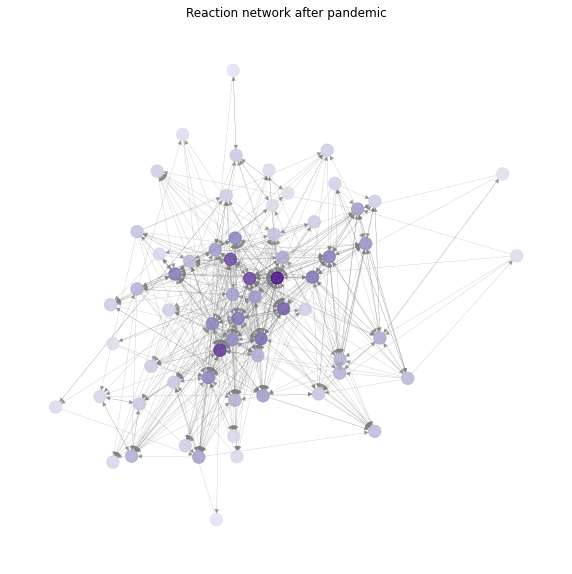

In [743]:
##### Plot networks
#G = networks['reaction_nw_before_c']
G = subgraphs['reaction_nw_after_c']
nodecolors = list(nx.degree_centrality(G).values())
options = {
    'cmap': 'Purples',
    #"edge_cmap": 'grey',
    "node_color": nodecolors,
    'alpha': 0.8,
    'node_size':150,
    #"edge_color": edgecolors,
    'edge_color': 'grey',
    "width": 0.2,
    #"edge_cmap": 'RdBu_r',
    "with_labels": False, 
    'vmin': -0.2,
    #'vmax': 1

}
plt.figure(figsize = (10,10))
plt.title('Reaction network after pandemic')
nx.draw(G, pos, **options)
plt.show()

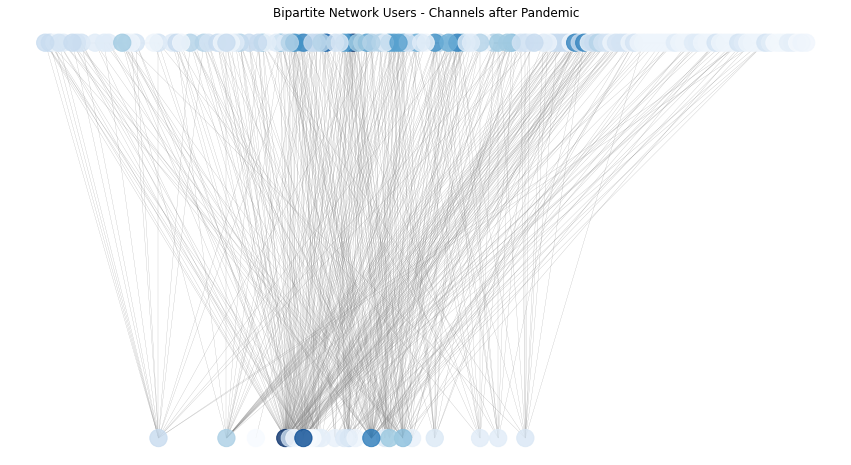

In [323]:

G = c_u_subgraphs['after_c']

#top_nodes, bottom_nodes= nx.algorithms.bipartite.basic.sets(G)

nodecolors = list(nx.algorithms.bipartite.centrality.degree_centrality(G, list(range(161))).values())
options = {
    'cmap': 'Blues',
    "node_color": nodecolors,
    'alpha': 0.8,
    #'node_size':100,
    'edge_color': 'grey',
    "width": 0.2,
    "with_labels": False, 

}
plt.figure(figsize = (15,8))
#plt.xlabel('Channels')
plt.title('Bipartite Network Users - Channels after Pandemic')
nx.draw(G, pos, **options)
plt.show()

In [677]:
##### Make measurements on whole network
#nw_names = ['channel_nw_before_c', 'channel_nw_after_c', 'thread_nw_before_c', 'thread_nw_after_c', 'reaction_nw_before_c', 'reaction_nw_after_c']

list_of_methods_nw = ['number_of_nodes', 'number_of_edges', 'diameter', 'average_shortest_path_length', 'graph_clique_number', 'average_clustering']
nw_data = pd.DataFrame(columns = list_of_methods_nw)

#for n in range(3):
for k, v in subgraphs.items():
    G = v
    nw_data_tmp = {}
    for j in list_of_methods_nw:
        method_to_call = getattr(nx, j)
        result = method_to_call(G)
        nw_data_tmp[j] = result
    nw_data.loc[k] = nw_data_tmp


nw_data.insert(1, 'relative_number_of_nodes', nw_data['number_of_nodes']/channel_nw_after_c.number_of_nodes())
nw_data.insert(3, 'average_degree', 0.5*nw_data['number_of_edges']/nw_data['number_of_nodes'])


In [736]:
nw_data

,number_of_nodes,relative_number_of_nodes,number_of_edges,average_degree,diameter,average_shortest_path_length,graph_clique_number,average_clustering
channel_nw_before_c,94,0.583851,1575,8.37766,3,1.688172,35,0.772830
channel_nw_after_c,147,0.913043,3459,11.7653,3,1.714286,39,0.799004
thread_nw_before_c,17,0.10559,22,0.647059,5,2.639706,3,0.203922
thread_nw_after_c,74,0.459627,166,1.12162,6,3.007034,6,0.353049
reaction_nw_before_c,76,0.47205,307,2.01974,4,2.295789,7,0.462696
reaction_nw_after_c,113,0.701863,622,2.75221,5,2.365834,10,0.405577
complete_network,161,1,4000,12.4224,3,1.725621,39,0.798785


In [678]:
nw_data

,number_of_nodes,relative_number_of_nodes,number_of_edges,average_degree,diameter,average_shortest_path_length,graph_clique_number,average_clustering
channel_nw_before_c,94,0.583851,1575,8.37766,3,1.688172,35,0.772830
channel_nw_after_c,147,0.913043,3459,11.7653,3,1.714286,39,0.799004
thread_nw_before_c,17,0.10559,22,0.647059,5,2.639706,3,0.203922
thread_nw_after_c,74,0.459627,166,1.12162,6,3.007034,6,0.353049
reaction_nw_before_c,76,0.47205,307,2.01974,4,2.295789,7,0.462696
reaction_nw_after_c,113,0.701863,622,2.75221,5,2.365834,10,0.405577
complete_network,161,1,4000,12.4224,3,1.725621,39,0.798785


In [636]:
##### Make measurements on nodes

list_of_methods_nodes = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality']
list_of_methods_edges = ['bridges']

G = c_u_subgraphs['before_c']

top_nodes_before, bottom_nodes_before= nx.algorithms.bipartite.basic.sets(G)
users_data_before_c = pd.DataFrame(columns = list_of_methods_nodes)

for j in list_of_methods_nodes:
    method_to_call = getattr(nx.algorithms.bipartite.centrality, j)
    result = method_to_call(G, top_nodes_before)
    users_data_before_c[j] = pd.Series(result)
    
G = c_u_subgraphs['after_c']

top_nodes_after, bottom_nodes_after= nx.algorithms.bipartite.basic.sets(G)
users_data_after_c = pd.DataFrame(columns = list_of_methods_nodes)

for j in list_of_methods_nodes:
    method_to_call = getattr(nx.algorithms.bipartite.centrality, j)
    result = method_to_call(G, top_nodes_after)
    users_data_after_c[j] = pd.Series(result)

AttributeError: module 'networkx.algorithms.bipartite.centrality' has no attribute 'cluster.clustering'

In [43]:
networks

{0: {'channel_user': <networkx.classes.graph.Graph at 0x7f8eddf3add8>,
  'user_user': <networkx.classes.graph.Graph at 0x7f8eddf426a0>,
  'thread': <networkx.classes.graph.Graph at 0x7f8ed902fcf8>,
  'reaction': <networkx.classes.digraph.DiGraph at 0x7f8ed902f518>},
 1: {'channel_user': <networkx.classes.graph.Graph at 0x7f8eddf426d8>,
  'user_user': <networkx.classes.graph.Graph at 0x7f8ed902fba8>,
  'thread': <networkx.classes.graph.Graph at 0x7f8ed902fe10>,
  'reaction': <networkx.classes.digraph.DiGraph at 0x7f8ed902fa90>}}

In [78]:
users_data = pd.DataFrame(users)

#### add network measurements to user data frame
for k, v in networks.items():
    for name, nw in v.items():
        if name == 'channel_user':
            list_of_methods = ['degree_centrality',  'betweenness_centrality', 'closeness_centrality']
            #top_nodes, bottom_nodes= nx.algorithms.bipartite.basic.sets(nw)
            #users_data_before_c = pd.DataFrame(columns = list_of_methods_nodes)
            top_nodes = list(range(len(users)))

            for j in list_of_methods:
                method_to_call = getattr(nx.algorithms.bipartite.centrality, j)
                result = method_to_call(nw, top_nodes)
                users_data[str(k)+'_'+j+'_'+name] = pd.Series(result).loc[:len(users)]
            
            
        if name == 'user_user' or name == 'thread':
            list_of_methods = ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'clustering']
            
            for i in list_of_methods:
                method_to_call = getattr(nx, i)
                result = method_to_call(nw)
                users_data[str(k)+'_'+i+'_'+name] = pd.Series(result)
            
        if name == 'reaction':
            list_of_methods = ['in_degree_centrality', 'out_degree_centrality']
            
            for i in list_of_methods:
                method_to_call = getattr(nx, i)
                result = method_to_call(nw)
                users_data[str(k)+'_'+ i+'_'+name] = pd.Series(result)

   
users_data = users_data.fillna(0)

In [82]:
users_data[1:].idxmax()

TypeError: reduction operation 'argmax' not allowed for this dtype

In [712]:
users_data.columns = [str(col) + '_reaction_after' for col in users_data.columns]

In [158]:

### ok but normalize them first!! scipy?
X = users_data.loc[:, users_data.columns != 0]
X_scaled = preprocessing.scale(X, axis = 0)[:, 13:]
####
#(users_data.loc[:, users_data.columns != 0].mean(axis = 1)).sort_values()

In [159]:
X_mean = X_scaled.mean(axis = 1)
indx = np.argsort(X_mean)[::-1]

In [160]:
indx

array([ 23,  45, 102,  66,  32,  76,   3,  30, 136,  49, 107,  95,  85,
        29,  34, 132, 115,  81,  65, 120,  78,  72,   1,  98, 126,  88,
         0,   2, 138,  73,  27,  42,  44, 157,  55, 124,  41,  90, 127,
       116, 148,  68,  62, 110,  86,  26,   4,  59, 130,  97, 123, 141,
        38, 160, 137,  89,  52, 122, 150, 119, 159,  91,  46,  82, 133,
        80,  56,  61, 134, 128,  92, 108, 103, 158,  84, 135,  36,  94,
        25, 155,  67, 156,  64,  87, 125, 109, 140, 145,  93,  39, 101,
       143,  35, 131, 149,  11, 151,  28,  10,   8,  31,   9, 147,  33,
       146, 152,  16,  17,   6,  24, 153,  12,  22,  13,  14,  21,   5,
       154,  15,  20,  19,  18,   7, 106,  37,  71,  75,  77, 121,  79,
        83, 118, 117, 114, 113, 112,  96, 111,  99, 100, 104,  74,  70,
        40,  69, 144,  43, 142,  47,  48, 139,  50,  51, 105,  54,  57,
        58,  60,  63, 129,  53])

In [130]:
(users_data.loc[:, users_data.columns != 0].idxmax())

0_degree_centrality_channel_user          23
0_betweenness_centrality_channel_user    116
0_closeness_centrality_channel_user        3
0_degree_centrality_user_user             23
0_eigenvector_centrality_user_user        23
0_betweenness_centrality_user_user        76
0_clustering_user_user                     4
0_degree_centrality_thread                32
0_eigenvector_centrality_thread           32
0_betweenness_centrality_thread           32
0_clustering_thread                        5
0_in_degree_centrality_reaction           23
0_out_degree_centrality_reaction          30
1_degree_centrality_channel_user          23
1_betweenness_centrality_channel_user      3
1_closeness_centrality_channel_user        3
1_degree_centrality_user_user             32
1_eigenvector_centrality_user_user       120
1_betweenness_centrality_user_user       136
1_clustering_user_user                     4
1_degree_centrality_thread                45
1_eigenvector_centrality_thread           45
1_betweenn

<BarContainer object of 27 artists>

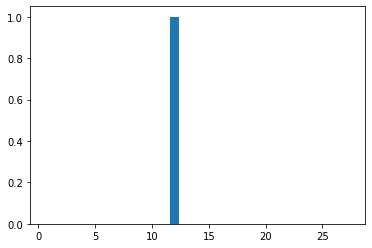

In [106]:
plt.bar(weeks, np.sum(total_weekly_nw['nw'][4, :, :], axis = 0))

In [541]:
user_stats_before_c = users_data_before_c.loc[[i for i in top_nodes_before]]
user_stats_before_c.columns = ['degree_centrality_before', 'betweenness_centrality_before', 'closeness_centrality_before']
user_stats_after_c = users_data_after_c.loc[[i for i in top_nodes_after]]

In [542]:
user_stats = pd.concat([user_stats_before_c, user_stats_after_c], axis = 1)
user_stats = user_stats.fillna(0)
user_stats['difference_degree_c'] = -user_stats['degree_centrality_before'] + user_stats['degree_centrality']
#user_stats = pd.concat([user_stats_before_c, user_stats_after_c], axis = 1)

In [696]:
#######Data about nodes!!
user_stats.columns =  [str(col) + '_channel' for col in user_stats.columns]

In [713]:
user_stats = pd.concat([user_stats, users_data], axis = 1)

In [724]:
user_stats.corr()

,degree_centrality_before_channel,betweenness_centrality_before_channel,closeness_centrality_before_channel,degree_centrality_channel,betweenness_centrality_channel,closeness_centrality_channel,difference_degree_c_channel,degree_centrality_u_u_c_before,eigenvector_centrality_u_u_c_before,betweenness_centrality_u_u_c_before,...,betweenness_centrality_thread_after,clustering_thread_after,degree_centrality_reaction_before,eigenvector_centrality_reaction_before,betweenness_centrality_reaction_before,clustering_reaction_before,degree_centrality_reaction_after,eigenvector_centrality_reaction_after,betweenness_centrality_reaction_after,clustering_reaction_after
degree_centrality_before_channel,1.000000,0.843823,0.790875,0.637729,0.557397,0.254633,-0.375999,0.854912,0.838194,0.668846,...,0.383260,0.096614,0.707399,0.758789,0.376038,0.477925,0.654180,0.691136,0.462412,0.315777
betweenness_centrality_before_channel,0.843823,1.000000,0.510938,0.557896,0.507317,0.266263,-0.293498,0.616635,0.583057,0.657313,...,0.459314,0.128153,0.565703,0.588364,0.335150,0.309538,0.538824,0.558085,0.434557,0.241735
closeness_centrality_before_channel,0.790875,0.510938,1.000000,0.366682,0.306981,0.043500,-0.462999,0.843770,0.850576,0.480662,...,0.251677,0.080128,0.575899,0.629520,0.285458,0.601193,0.538350,0.561168,0.341749,0.349091
degree_centrality_channel,0.637729,0.557896,0.366682,1.000000,0.872706,0.642598,0.473954,0.549231,0.534356,0.509621,...,0.355525,0.165707,0.538186,0.577087,0.300281,0.308372,0.690508,0.719851,0.507872,0.387244
betweenness_centrality_channel,0.557397,0.507317,0.306981,0.872706,1.000000,0.399465,0.412654,0.446254,0.433866,0.423855,...,0.317679,0.140804,0.460304,0.475008,0.297642,0.224965,0.589963,0.592905,0.550863,0.202136
closeness_centrality_channel,0.254633,0.266263,0.043500,0.642598,0.399465,1.000000,0.481951,0.266362,0.247226,0.292771,...,0.211820,0.217905,0.308137,0.323434,0.166474,0.123578,0.467522,0.491420,0.277214,0.391508
difference_degree_c_channel,-0.375999,-0.293498,-0.462999,0.473954,0.412654,0.481951,1.000000,-0.316600,-0.315382,-0.151542,...,-0.010442,0.088897,-0.161252,-0.173203,-0.068644,-0.175387,0.082830,0.075881,0.082345,0.104862
degree_centrality_u_u_c_before,0.854912,0.616635,0.843770,0.549231,0.446254,0.266362,-0.316600,1.000000,0.993381,0.728306,...,0.391275,0.038489,0.791900,0.851827,0.470667,0.544849,0.703915,0.723790,0.516618,0.353810
eigenvector_centrality_u_u_c_before,0.838194,0.583057,0.850576,0.534356,0.433866,0.247226,-0.315382,0.993381,1.000000,0.662577,...,0.345294,0.028650,0.747300,0.815184,0.426497,0.544982,0.666315,0.693269,0.471404,0.362069
betweenness_centrality_u_u_c_before,0.668846,0.657313,0.480662,0.509621,0.423855,0.292771,-0.151542,0.728306,0.662577,1.000000,...,0.686317,0.029538,0.746794,0.763024,0.548190,0.263351,0.719517,0.696024,0.698332,0.164686


Text(0.5, 1.0, 'Degree centrality distribution of users before the pandemic')

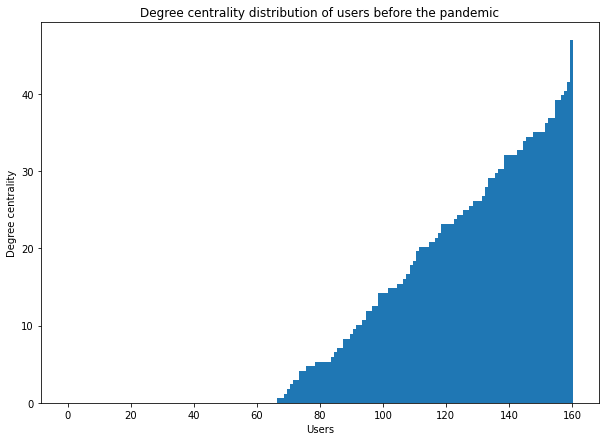

In [726]:
plt.figure(figsize=(10,7))
sorted_c_stats = user_stats.sort_values('degree_centrality_u_u_c_before')
#plt.bar(list(range(161)), sorted_c_stats['degree_centrality_before']*42, label = 'Degree before pandemic')
plt.bar(list(range(161)), sorted_c_stats['degree_centrality_u_u_c_before']*95, label='Degree after pandemic', width = 1)
#plt.legend()
plt.xlabel('Users')
plt.ylabel('Degree centrality')
#plt.ylim(0, 25)
plt.title('Degree centrality distribution of users before the pandemic')

Text(0.5, 1.0, 'Degree centrality distribution of users before the pandemic')

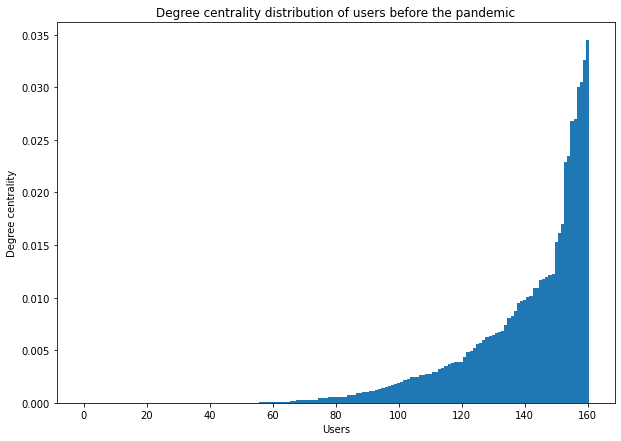

In [721]:
plt.figure(figsize=(10,7))
sorted_c_stats = user_stats.sort_values('betweenness_centrality_u_u_c_after')
#plt.bar(list(range(161)), sorted_c_stats['degree_centrality_before']*42, label = 'Degree before pandemic')
plt.bar(list(range(161)), sorted_c_stats['betweenness_centrality_u_u_c_after'], label='Degree after pandemic', width = 1)
#plt.legend()
plt.xlabel('Users')
plt.ylabel('Degree centrality')
#plt.ylim(0, 25)
plt.title('Degree centrality distribution of users before the pandemic')

Text(0.5, 1.0, 'Divergence in degree centrality ')

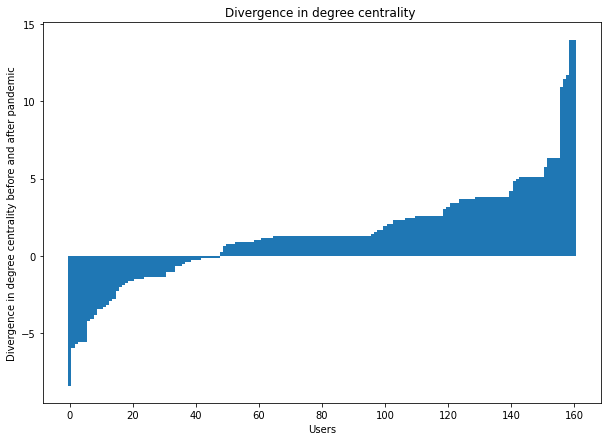

In [632]:
plt.figure(figsize=(10,7))
sorted_c_stats = user_stats.sort_values('difference_degree_c')
plt.bar(list(range(161)), sorted_c_stats['difference_degree_c']*42, label = 'Degree before pandemic', width = 1)
#plt.legend()
plt.xlabel('Users')
plt.ylabel('Divergence in degree centrality before and after pandemic')
plt.title('Divergence in degree centrality ')

In [549]:
most_important_betweenness_before = user_stats.sort_values('betweenness_centrality_before').index[:35:-1]
most_important_betweenness_after = user_stats.sort_values('betweenness_centrality').index[:37:-1]

most_important_degree_before = user_stats.sort_values('degree_centrality_before').index[:37:-1]
most_important_degree_after = user_stats.sort_values('degree_centrality').index[:37:-1]

most_important_closeness_before = user_stats.sort_values('closeness_centrality_before').index[:37:-1]
most_important_closeness_after = user_stats.sort_values('closeness_centrality').index[:37:-1]

In [397]:
user_stats.sort_values('betweenness_centrality_before').index[:37:-1]

Int64Index([178, 195, 189, 191], dtype='int64')

In [628]:
### How to capture how degree centrality has changed???

imdx = user_stats[user_stats['difference_degree_c']*42 < 10].index
users[imdx]

array(['U01026MQ4Q4', 'U0103R93TJR', 'U01046P5G6M', 'U010868USDS',
       'U010DAWCE90', 'U010UCSK25B', 'U0115LXTCBZ', 'U01189DAVE2',
       'U011CRVUK29', 'U011THL3TNF', 'U0129U6CF5H', 'U012P37UWGZ',
       'U013HA6GXJM', 'U013X1RB8BA', 'U013Z1L3534', 'U013Z4CTX63',
       'U015RQ8M52B', 'U0168K6TC6N', 'U0168QQFX7T', 'U016T80L5CM',
       'U2XA06NJV', 'U2XEESCG1', 'U2XEP2PCG', 'U2XPEN5MF', 'U2Y51106N',
       'U2Y8G717G', 'U2YA14ABU', 'U2YBCCULE', 'U2YJ26HR8', 'U2YMKNHU5',
       'U2YPP2Q0J', 'U2YSDPZU7', 'U2YTKRHT9', 'U2Z0F5BN2', 'U2Z4U0Q3T',
       'U2Z7NV1LZ', 'U2Z9F2E3E', 'U2ZK7G12M', 'U2ZPT5Z7U', 'U2ZPT8DJN',
       'U2ZSW3AAK', 'U306BNRRT', 'U30CE977G', 'U30DCR571', 'U30E832HL',
       'U30U93JKS', 'U313G51DX', 'U31SYU069', 'U31T1NELB', 'U322FHEN4',
       'U32662EQ2', 'U326X4F51', 'U32G09Y0P', 'U32TD1ATY', 'U33QTTSDQ',
       'U33TVR42J', 'U33V6UECX', 'U34CPD5HR', 'U34KE7B32', 'U34KX96JX',
       'U370UH5NK', 'U38ERNP62', 'U3E6RSSPR', 'U3SUD8248', 'U3UD8MPUK',
       'U3WSETGLT

In [634]:
np.max(user_stats)*42

degree_centrality_before         16.800000
betweenness_centrality_before     2.793534
closeness_centrality_before      32.013986
degree_centrality                22.909091
betweenness_centrality            2.571378
closeness_centrality             35.488372
difference_degree_c              14.000000
dtype: float64

In [561]:
imdx = user_stats[user_stats['difference_degree_c']*42 >  10].index
users[imdx]

array(['U0104S7DUJ2', 'U011T6ZNW74', 'U011V0BTG06', 'U2WRCJ2PJ',
       'U2XG9LVS5'], dtype=object)

In [22]:
####### GET STATS FROM NETWORKS

pure_posts_nw = make_channel_network(data[data['parent_user_id'].isnull()], users, channels)
thread_nw = make_channel_network(data[~data['parent_user_id'].isnull()], users, channels)
reaction_nw = make_channel_network(reaction_data, users, channels)

abs_ts, channel_nws = same_timescale(pure_posts_nw, thread_nw, reaction_nw)

In [23]:
#### get weekly posts:
pure_posts_nw_weekly = make_time_network(channel_nws[0], abs_ts , 'week')['nw']
thread_nw_weekly = make_time_network(channel_nws[1], abs_ts , 'week')['nw']
reaction_nw_weekly = make_time_network(channel_nws[2], abs_ts , 'week')['nw']
weekly_ts = make_time_network(channel_nws[0], abs_ts , 'week')['ts']


weekly_nws = {'pure_posts': pure_posts_nw_weekly, 'thread': thread_nw_weekly, 'reaction': reaction_nw_weekly}

In [24]:
#### stats per user

user_data_stats = pd.DataFrame()
stats = dict.fromkeys(weekly_nws.keys(),[])

for k, v in weekly_nws.items():
    m = np.sum(np.sum(v, axis = 1), axis=1)
    stats[k] = m
    
user_data_stats = pd.DataFrame(stats)

In [247]:
tot_user_data = pd.concat([user_data_stats, users_data], axis = 1)

In [248]:
tot_user_data.corr()

,pure_posts,thread,reaction,degree_centrality,betweenness_centrality,clustering,eigenvector_centrality
pure_posts,1.000000,0.554441,0.424522,0.509040,0.469899,-0.267336,0.474342
thread,0.554441,1.000000,0.471501,0.473883,0.515349,-0.300186,0.435259
reaction,0.424522,0.471501,1.000000,0.787821,0.754463,-0.386082,0.727354
degree_centrality,0.509040,0.473883,0.787821,1.000000,0.757126,-0.394117,0.987499
betweenness_centrality,0.469899,0.515349,0.754463,0.757126,1.000000,-0.432205,0.664847
clustering,-0.267336,-0.300186,-0.386082,-0.394117,-0.432205,1.000000,-0.345065
eigenvector_centrality,0.474342,0.435259,0.727354,0.987499,0.664847,-0.345065,1.000000


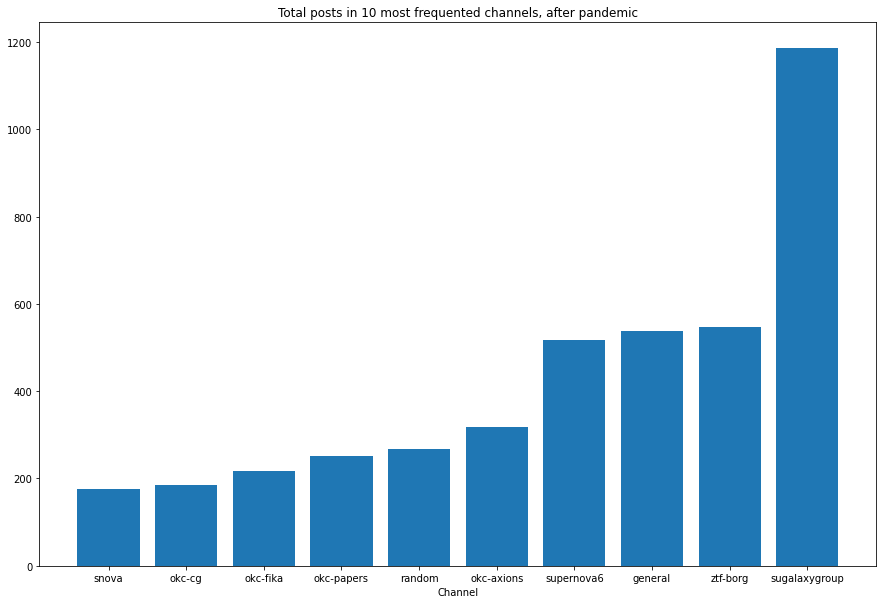

In [518]:
#frequency_posts = dict.fromkeys(weekly_nws.keys(),[])
total_nw = np.zeros(np.shape(weekly_nws['pure_posts']), dtype = int)
for k, v in weekly_nws.items():
    total_nw = total_nw + v

m = np.sum(np.sum(total_nw[:, :, 11:], axis = 0), axis=1)
indx = np.argsort(m)[32:]
frequency_posts = m[indx]

    
plt.figure(figsize=(15,10))

plt.bar(list(range(10)), frequency_posts)
plt.xticks(list(range(10)), channels[indx])
plt.xlabel('Channel')
plt.title('Total posts in 10 most frequented channels, after pandemic')
#plt.legend()
plt.show()



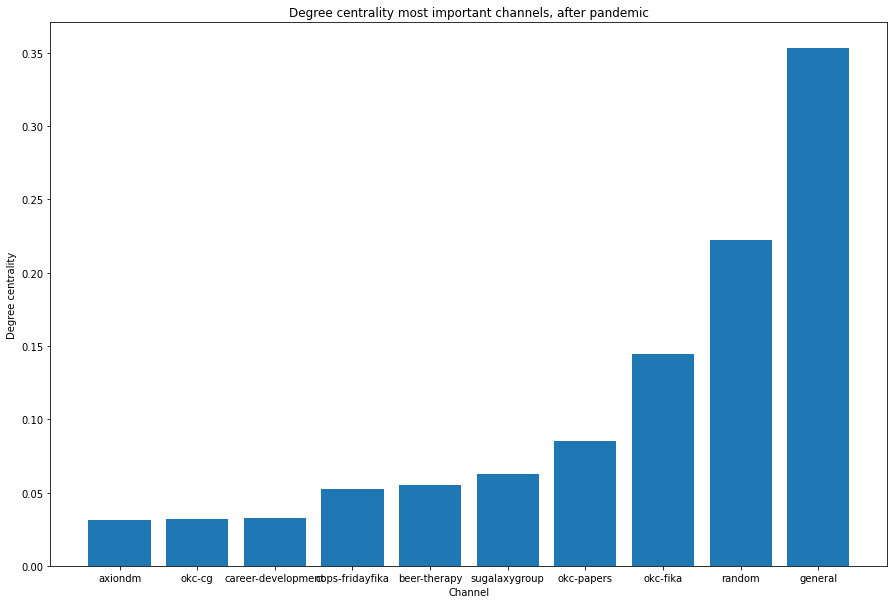

In [532]:
m = channel_stats['betweenness_centrality_before'].values
indx = np.argsort(m)[32:]
frequency_posts = m[indx]

    
plt.figure(figsize=(15,10))

plt.bar(list(range(10)), frequency_posts)
plt.xticks(list(range(10)), channels[indx])
plt.xlabel('Channel')
plt.ylabel('Degree centrality')
plt.title('Degree centrality most important channels, after pandemic')
#plt.legend()
plt.show()

In [523]:
data_channels = [channel_stats['degree_centrality_before'].values, 

array([0.02654867, 0.12389381, 0.05309735, 0.        , 0.05309735,
       0.        , 0.24778761, 0.        , 0.        , 0.00884956,
       0.18584071, 0.02654867, 0.22123894, 0.        , 0.01769912,
       0.07079646, 0.        , 0.61946903, 0.03539823, 0.01769912,
       0.00884956, 0.        , 0.01769912, 0.05309735, 0.12389381,
       0.12389381, 0.21238938, 0.05309735, 0.31858407, 0.07964602,
       0.27433628, 0.07079646, 0.0619469 , 0.00884956, 0.51327434,
       0.09734513, 0.        , 0.14159292, 0.07079646, 0.00884956,
       0.02654867, 0.        ])

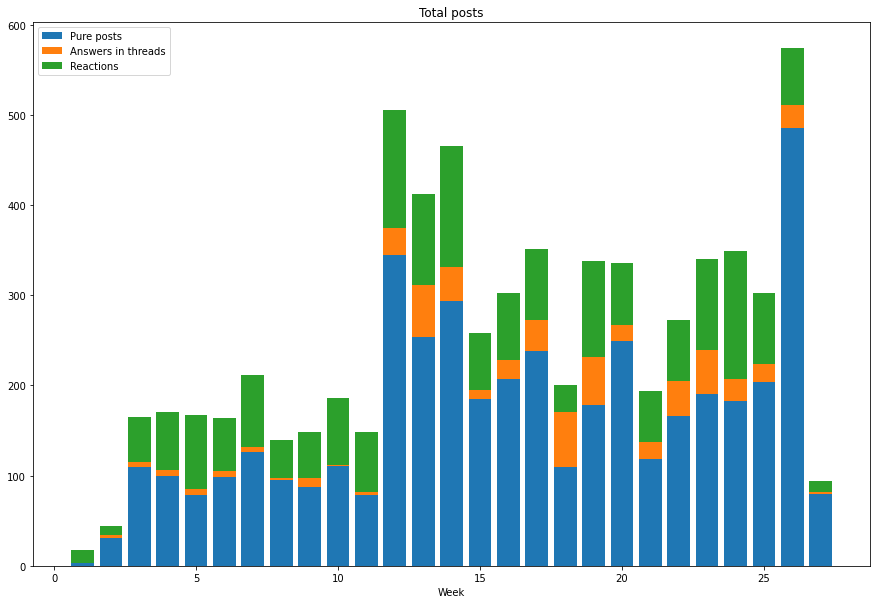

In [745]:
#### Total posts:

frequency_posts = dict.fromkeys(weekly_nws.keys(),[])

for k, v in weekly_nws.items():
    m = np.sum(np.sum(v, axis = 1), axis=0)
    frequency_posts[k] = m
    
plt.figure(figsize=(15,10))

plt.bar(weekly_ts, frequency_posts['pure_posts'],label='Pure posts')
plt.bar(weekly_ts, frequency_posts['thread'],  bottom=frequency_posts['pure_posts'],
       label='Answers in threads')
plt.bar(weekly_ts, frequency_posts['reaction'],  bottom=(frequency_posts['pure_posts']+frequency_posts['thread']),
       label='Reactions')
plt.xlabel('Week')
plt.title('Total posts')
plt.legend()
plt.show()

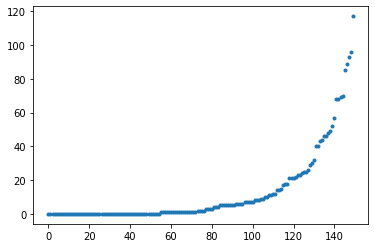

In [761]:
plt.plot(np.sort(np.sum(np.sum(weekly_nws['reaction'], axis = 2), axis = 1)), '.')

<BarContainer object of 42 artists>

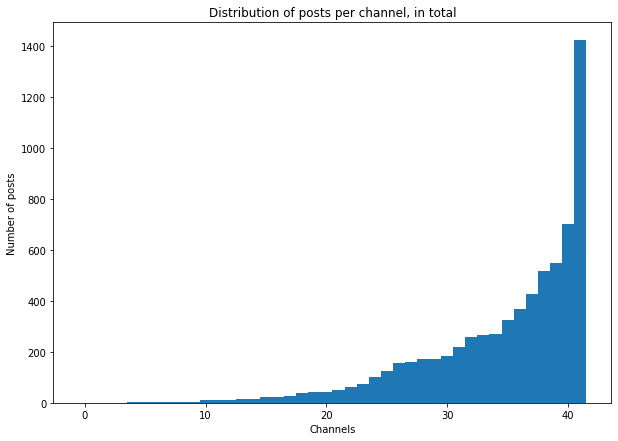

In [785]:
tot_nw = weekly_nws['pure_posts'] + weekly_nws['reaction'] + weekly_nws['thread']
plt.figure(figsize=(10,7))
plt.title('Distribution of posts per channel, in total')
plt.xlabel('Channels')
plt.ylabel('Number of posts')
plt.bar(list(range(42)), np.sort(np.sum(np.sum(tot_nw, axis = 2), axis = 0)), width = 1)

In [770]:
np.shape(tot_nw)

(161, 42, 27)

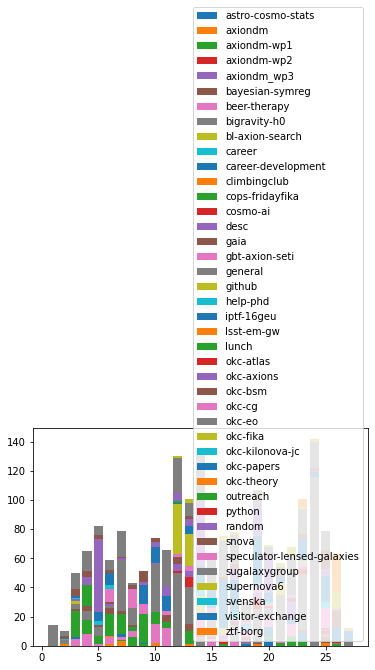

In [301]:

bottom = np.zeros(27)
for i in range(42):
    plt.bar(weekly_ts, frequency_posts['reaction'][i, :], bottom = bottom, label=channels[i])
    bottom = bottom + frequency_posts['reaction'][i, :]
plt.legend()
    

In [26]:
channels

array(['astro-cosmo-stats', 'axiondm', 'axiondm-wp1', 'axiondm-wp2',
       'axiondm_wp3', 'bayesian-symreg', 'beer-therapy', 'bigravity-h0',
       'bl-axion-search', 'career', 'career-development', 'climbingclub',
       'cops-fridayfika', 'cosmo-ai', 'desc', 'gaia', 'gbt-axion-seti',
       'general', 'github', 'help-phd', 'iptf-16geu', 'lsst-em-gw',
       'lunch', 'okc-atlas', 'okc-axions', 'okc-bsm', 'okc-cg', 'okc-eo',
       'okc-fika', 'okc-kilonova-jc', 'okc-papers', 'okc-theory',
       'outreach', 'python', 'random', 'snova',
       'speculator-lensed-galaxies', 'sugalaxygroup', 'supernova6',
       'svenska', 'visitor-exchange', 'ztf-borg'], dtype=object)

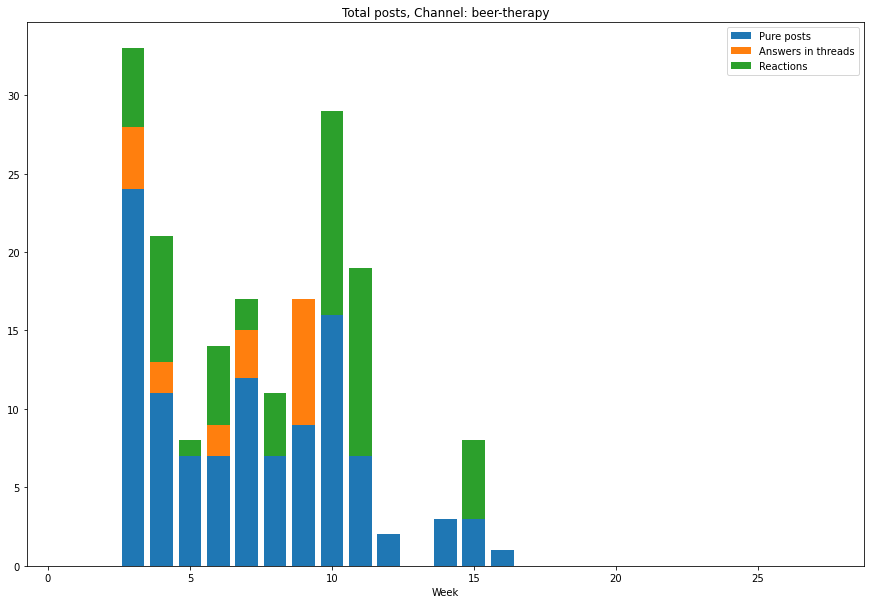

In [505]:
### posts per channel

frequency_posts = dict.fromkeys(weekly_nws.keys(),[])
channel_name = 'beer-therapy'
channel_indx = np.nonzero(channels == channel_name)[0][0]


for k, v in weekly_nws.items():
    m = np.sum(v[:, channel_indx, :], axis = 0)
    frequency_posts[k] = m
    
plt.figure(figsize=(15,10))

plt.bar(weekly_ts, frequency_posts['pure_posts'],label='Pure posts')
plt.bar(weekly_ts, frequency_posts['thread'],  bottom=frequency_posts['pure_posts'],
       label='Answers in threads')
plt.bar(weekly_ts, frequency_posts['reaction'],  bottom=(frequency_posts['pure_posts']+frequency_posts['thread']),
       label='Reactions')
plt.xlabel('Week')
plt.title('Total posts, Channel: '+ channel_name)
plt.legend()
plt.show()

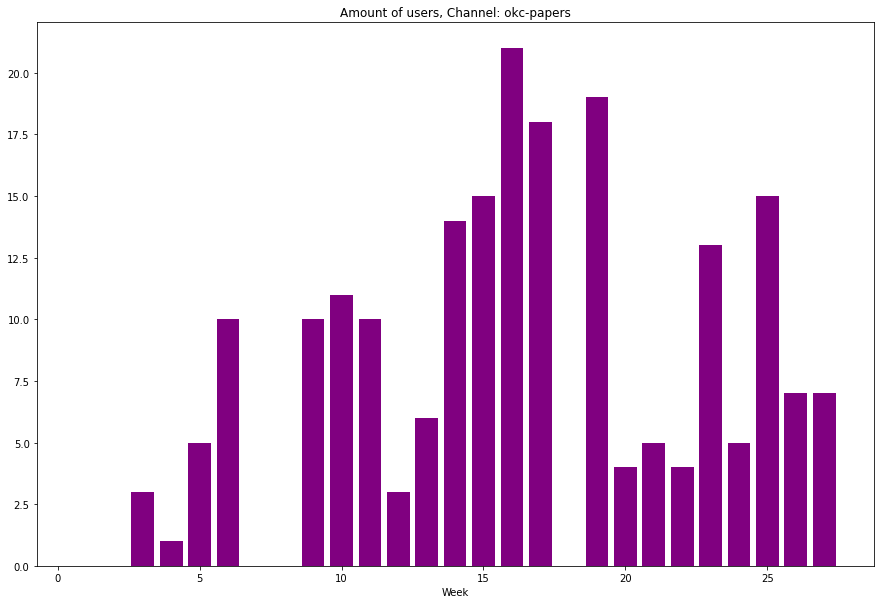

In [536]:
### active users per channel

frequency_posts = dict.fromkeys(weekly_nws.keys(),[])
channel_name = 'okc-papers'
channel_indx = np.nonzero(channels == channel_name)[0][0]

total_nw = np.zeros(np.shape(weekly_nws['pure_posts']), dtype = int)
for k, v in weekly_nws.items():
    total_nw = total_nw + v
    
    
    
    
    
m = np.sum(np.sign(total_nw[:, channel_indx, :]), axis = 0)
frequency_posts = m
    
plt.figure(figsize=(15,10))

plt.bar(weekly_ts, frequency_posts, color='purple')

plt.xlabel('Week')
plt.title('Amount of users, Channel: '+ channel_name)
#plt.legend()
plt.show()

In [61]:
channels

array(['astro-cosmo-stats', 'axiondm', 'axiondm-wp1', 'axiondm-wp2',
       'axiondm_wp3', 'bayesian-symreg', 'beer-therapy', 'bigravity-h0',
       'bl-axion-search', 'career', 'career-development', 'climbingclub',
       'cops-fridayfika', 'cosmo-ai', 'desc', 'gaia', 'gbt-axion-seti',
       'general', 'github', 'help-phd', 'iptf-16geu', 'lsst-em-gw',
       'lunch', 'okc-atlas', 'okc-axions', 'okc-bsm', 'okc-cg', 'okc-eo',
       'okc-fika', 'okc-kilonova-jc', 'okc-papers', 'okc-theory',
       'outreach', 'python', 'random', 'snova',
       'speculator-lensed-galaxies', 'sugalaxygroup', 'supernova6',
       'svenska', 'visitor-exchange', 'ztf-borg'], dtype=object)

In [88]:
#### Plot per user, WAAAIT the reaction network is directed!
### have to use the reaction network and not the channel network!
### make stats to reactions per user, how many answers they get per thread, and so on.
### plot in colors of channels! 
### maybe even: network of threads? (not of users)
### ok fuck it i need to save the matrixes as a dict

frequency_posts = dict.fromkeys(networks[0].keys(), [])
#frequency_posts = dict.fromkeys(weekly_nws.keys(),[])

user_indx = 44
user_name = users[user_indx]

for k, v in weekly_nws.items():
    m = np.sum(v[user_indx, :, :], axis = 0)
    frequency_posts[k] = m
    
plt.figure(figsize=(15,10))

plt.bar(weekly_ts, frequency_posts['pure_posts'],label='Pure posts')
plt.bar(weekly_ts, frequency_posts['thread'],  bottom=frequency_posts['pure_posts'],
       label='Answers in threads')
plt.bar(weekly_ts, frequency_posts['reaction'],  bottom=(frequency_posts['pure_posts']+frequency_posts['thread']),
       label='Reactions')
plt.xlabel('Week')
plt.title('Total posts per user, user: '+ user_name)
plt.legend()
plt.show()

NameError: name 'weekly_nws' is not defined

In [38]:
reaction_nw_dir = make_reaction_network(reaction_data, users)
thread_nw_dir = make_reaction_network(threads_data, users)

nw_dir = same_timescale(reaction_nw_dir, thread_nw_dir)

reaction_nw_dir = make_time_network(nw_dir[1][0], nw_dir[0], 'week')
thread_nw_dir = make_time_network(nw_dir[1][0], nw_dir[0], 'week')
weekly_dir = reaction_nw_dir['ts']
weekly_nw_dir = {'reaction': reaction_nw_dir['nw'], 'thread': thread_nw_dir['nw']}


In [89]:
### plot threads and so on
#### add_ posts that they made, add bars next to each other! 
#### do this sorted for all the users, not just timeline

frequency_posts_in = dict.fromkeys(weekly_nw_dir.keys(),[])
frequency_posts_out = dict.fromkeys(weekly_nw_dir.keys(), [])

user_indx = 44
user_name = users[user_indx]


v = weekly_nws['pure_posts']
m = np.sum(v[user_indx, :, :], axis = 0)
frequency_posts = m


for k, v in weekly_nw_dir.items():
    m = np.sum(v[user_indx, :, :], axis = 0)
    frequency_posts_in[k] = m
    out = np.sum(v[:, user_indx, :], axis = 0)
    frequency_posts_out[k] = out
    
width = 0.25   
plt.figure(figsize=(15,10))

plt.bar(weekly_dir, frequency_posts, label='Original posts', width = width)
#plt.bar(weekly_dir, frequency_posts_in['thread'],  bottom=frequency_posts_in['reaction'], label='Answers in threads in', width = width)

plt.bar(weekly_dir+width, frequency_posts_in['reaction'],label='Given reactions', width = width)
plt.bar(weekly_dir+width, frequency_posts_in['thread'],  bottom=frequency_posts_in['reaction'], label='Given answers to threads', width = width)

plt.bar(weekly_dir+2*width, frequency_posts_out['reaction'],label='Reactions to posts', width = width)
plt.bar(weekly_dir+2*width, frequency_posts_out['thread'],  bottom=frequency_posts_out['reaction'], label='Answers to threads', width = width)

plt.xlabel('Week')
plt.title('Total posts per user, user: '+ user_name)
plt.legend()
plt.show()

NameError: name 'weekly_nw_dir' is not defined

In [292]:
#top_nodes = {i for i in range(len(users))}
list_of_methods_nodes = ['degree_centrality',  'betweenness_centrality', 'clustering']
list_of_methods_nw = ['average_path_length', ]
tnw_data = []
### before and after corona

for i in [
    #np.sum(total_nw_weekly[:, :, :12], axis = 2),
          np.sum(total_nw_weekly[:, :, 12:], axis = 2)
         ]:

    nw_i_matrix = sparse.csr_matrix(i)

    nw_i_bipartite = nx.algorithms.bipartite.from_biadjacency_matrix(nw_i_matrix, edge_attribute='weight')

    top_nodes = {n for n, d in nw_i_bipartite.nodes(data=True) if d["bipartite"] == 0}
    nw_i = nx.algorithms.bipartite.weighted_projected_graph(nw_i_bipartite, top_nodes)
    


    users_data = pd.DataFrame(users, columns=['user id'])

    #### add network measurements to user data fram

    for j in list_of_methods_nodes:
        method_to_call = getattr(nx, j)
        result = method_to_call(nw_i)
        users_data[j] = pd.Series(result)
    tnw_data.append(users_data)

tnw_data = np.array(tnw_data)

In [380]:
#################
#################
# Make a network with channels and nodes: weekly channels.
# To be connected, two nodes have to post in the same channel at least in one week

## before Corona (week 12)
nwcn_before_c = np.zeros((len(users), len(users)), dtype = int)

for w in range(12):
    connections = np.nonzero(total_nw[:, :, w])

    for i in np.unique(connections[1]):
        indx = np.nonzero(connections[1] == i)
        same_channel = connections[0][indx]
        for j in same_channel:
            nwcn_before_c[j, same_channel] += 1

    for j in range(len(users)):
        nwcn_before_c[j][j] = 0
        
        
nwcn_after_c = np.zeros((len(users), len(users)), dtype = int)

for w in range(12, np.shape(total_nw)[2]):
    connections = np.nonzero(total_nw[:, :, w])

    for i in np.unique(connections[1]):
        indx = np.nonzero(connections[1] == i)
        same_channel = connections[0][indx]
        for j in same_channel:
            nwcn_after_c[j, same_channel] += 1

    for j in range(len(users)):
        nwcn_after_c[j][j] = 0        


In [381]:
channel_nw_before_c = nx.from_numpy_matrix(nwcn_before_c)
channel_nw_after_c = nx.from_numpy_matrix(nwcn_after_c)

In [356]:
np.shape(nwcn[same_channel, same_channel])

(7,)

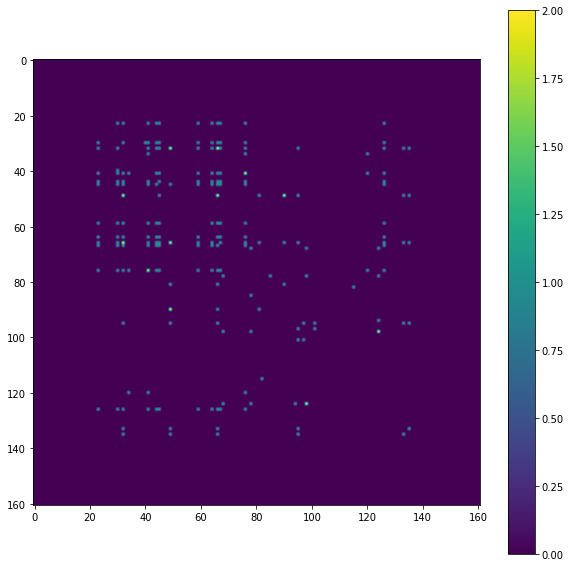

In [384]:
plt.figure(figsize=(10,10))
plt.imshow(nwcn_before_c)
plt.colorbar()

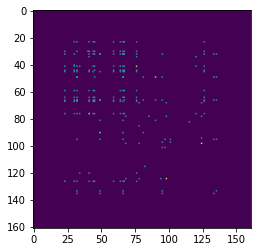

In [386]:
plt.imshow(nwcn_before_c)

In [302]:
##### measure things for networks before and after c:
networks = [before_c, after_c]
###subgraphs:

G = before_c
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
component_sizes = [c.size() for c in S]
subgraphs_indx = np.nonzero(component_sizes)[0]

maxcc_indx = np.argmax(component_sizes)
maxcc_before_c = S[maxcc_indx]

G = after_c
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
component_sizes = [c.size() for c in S]
subgraphs_indx = np.nonzero(component_sizes)[0]

maxcc_indx = np.argmax(component_sizes)
maxcc_after_c = S[maxcc_indx]

    


#nx.barycenter(after_c)

In [305]:
nx.average_shortest_path_length(maxcc_after_c)

1.467045942464577

In [307]:
nx.diameter(maxcc_before_c)

3

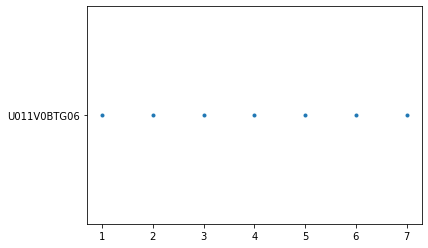

In [263]:
plt.plot(weeks, tnw_data[:, 12, 0], '.')

In [192]:
tnw_data

array([], dtype=float64)

In [187]:
tnw_data[0, 0, 0]

TypeError: list indices must be integers or slices, not tuple

In [142]:
B = nw_1_bipartite

top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}

bottom_nodes = set(B) - top_nodes

In [161]:
top_nodes = {i for i in range(len(users))}

In [173]:
nw_1.edges(data = True)

TypeError: 'EdgeDataView' object is not subscriptable

In [310]:
#### make a directed network out of reactions

network = make_reaction_network(reaction_data, users)
nw_tmp = np.sum(network['nw'], axis = 2)
nw = nx.DiGraph(nw_tmp)

In [315]:
G = nw
S = [G.subgraph(c).copy() for c in nx.weakly_connected_components(G)]
component_sizes = [c.size() for c in S]
subgraphs_indx = np.nonzero(component_sizes)[0]

maxcc_indx = np.argmax(component_sizes)
maxcc = S[maxcc_indx]

undir_maxcc = maxcc.to_undirected()

[5112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [62]:
most_active_channel_subgraph = [most_active_channel[i] for i in list(range(len(users))) if i in undir_maxcc.nodes()]

In [309]:
channels

array(['astro-cosmo-stats', 'axiondm', 'axiondm-wp1', 'axiondm-wp2',
       'axiondm_wp3', 'bayesian-symreg', 'beer-therapy', 'bigravity-h0',
       'bl-axion-search', 'career', 'career-development', 'climbingclub',
       'cops-fridayfika', 'cosmo-ai', 'desc', 'gaia', 'gbt-axion-seti',
       'general', 'github', 'help-phd', 'iptf-16geu', 'lsst-em-gw',
       'lunch', 'okc-atlas', 'okc-axions', 'okc-bsm', 'okc-cg', 'okc-eo',
       'okc-fika', 'okc-kilonova-jc', 'okc-papers', 'okc-theory',
       'outreach', 'python', 'random', 'snova',
       'speculator-lensed-galaxies', 'sugalaxygroup', 'supernova6',
       'svenska', 'visitor-exchange', 'ztf-borg'], dtype=object)

In [69]:
nx.betweenness_centrality(undir_maxcc).values()

dict_values([0.0, 0.0015265230456145257, 0.0, 0.0, 0.0, 9.547627012068448e-05, 0.0, 0.0012981499748520606, 0.0, 0.0, 0.1598852217842002, 0.0, 9.654227273207037e-05, 0.003861830222657367, 0.004364809155810109, 0.0, 0.005071672814242432, 0.15856945610181228, 0.0003933567240956152, 0.13540460365031318, 0.013116319641329258, 0.0006318429364405632, 0.0015134373076038019, 0.038544442973712054, 0.0, 0.0, 0.011647755992361935, 0.024427292664096774, 0.0002792353780356594, 0.0034664653548176186, 0.014399859034099655, 0.0, 0.0004940583475551181, 0.0010077483651518154, 0.01765209610533548, 0.0, 0.020468316454861014, 6.198347107438017e-05, 0.0, 0.0, 0.0005752077661203943, 0.00024541049180543426, 0.0, 0.009308726441412125, 0.0004990665878681371, 0.003152296227165792, 0.0, 0.047680561703722424, 0.000629754102095949, 0.024118541074454346, 0.0, 0.016528925619834708, 0.00030887392576936, 0.03416590277573783, 0.037061700287670925, 0.004777604997552962, 0.0970588369620962, 0.004033172772192951, 0.00473421

In [165]:
nw_1.edges()

EdgeView([(23, 32), (23, 64), (23, 66), (23, 67), (23, 41), (23, 44), (23, 45), (23, 76), (23, 126), (23, 59), (23, 30), (30, 32), (30, 64), (30, 66), (30, 67), (30, 41), (30, 44), (30, 45), (30, 76), (30, 59), (30, 126), (32, 64), (32, 66), (32, 67), (32, 41), (32, 44), (32, 45), (32, 76), (32, 126), (32, 59), (41, 64), (41, 66), (41, 67), (41, 44), (41, 45), (41, 76), (41, 126), (41, 59), (44, 64), (44, 66), (44, 67), (44, 76), (44, 45), (44, 126), (44, 59), (45, 64), (45, 66), (45, 67), (45, 76), (45, 126), (45, 59), (59, 64), (59, 66), (59, 67), (59, 76), (59, 126), (64, 66), (64, 67), (64, 76), (64, 126), (66, 67), (66, 76), (66, 126), (67, 76), (67, 126), (76, 126)])

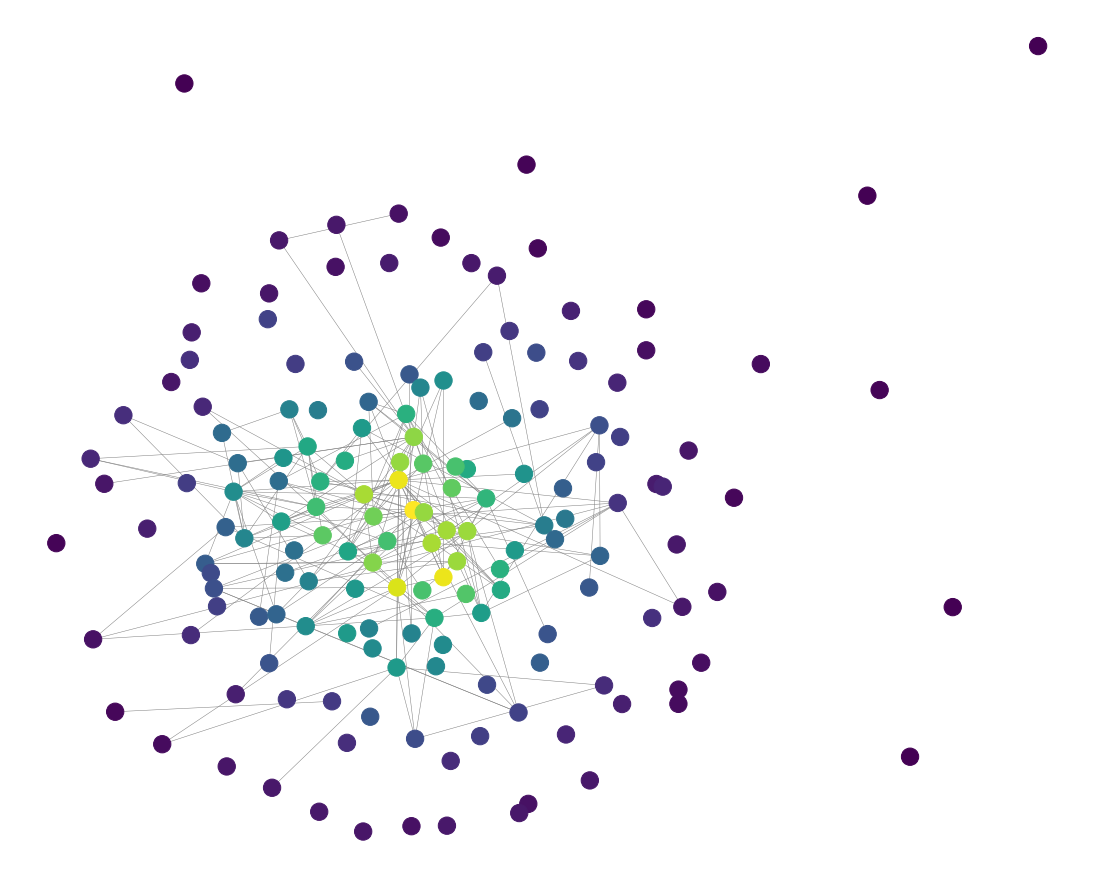

In [406]:
#G= channel_nw_before_c
G = G_threads
#G = maxcc_threads
#pos = nx.drawing.nx_agraph.graphviz_layout(G, prog = 'neato')

#edgecolors = list(nx.edge_betweenness_centrality(G).values())

bridges = list(nx.bridges(G))
edgecolors = ['r' if i in bridges else 'grey' for i in G.edges()]

#most_active_channel_subgraph = [most_active_channel[i] for i in list(range(len(users))) if i in undir_maxcc.nodes()]

nodecolors = list(nx.degree_centrality(channel_nw_after_c).values())
#colors = edgecolors

#nodecolors = most_active_channel_subgraph
options = {
    #"edge_cmap": 'grey',
    "node_color": nodecolors,
    #'alpha': 0.2,
    "edge_color": edgecolors,
    'edge_color': 'grey',
    "width": 0.5,
    #"node_size": 20,
    #"edge_cmap": 'RdBu_r',
    "with_labels": False, 

}
plt.figure(figsize = (15,12))
#plt.title('out-degree-centrality')
nx.draw(G, pos, **options)
plt.show()

In [322]:
bridges

[(2, 38),
 (5, 76),
 (11, 32),
 (13, 70),
 (22, 68),
 (23, 28),
 (23, 46),
 (23, 91),
 (23, 112),
 (24, 32),
 (30, 58),
 (30, 139),
 (32, 104),
 (39, 42),
 (52, 76),
 (55, 93),
 (57, 72),
 (61, 76),
 (66, 92),
 (69, 95),
 (73, 134),
 (102, 137),
 (111, 118),
 (115, 140),
 (146, 150)]

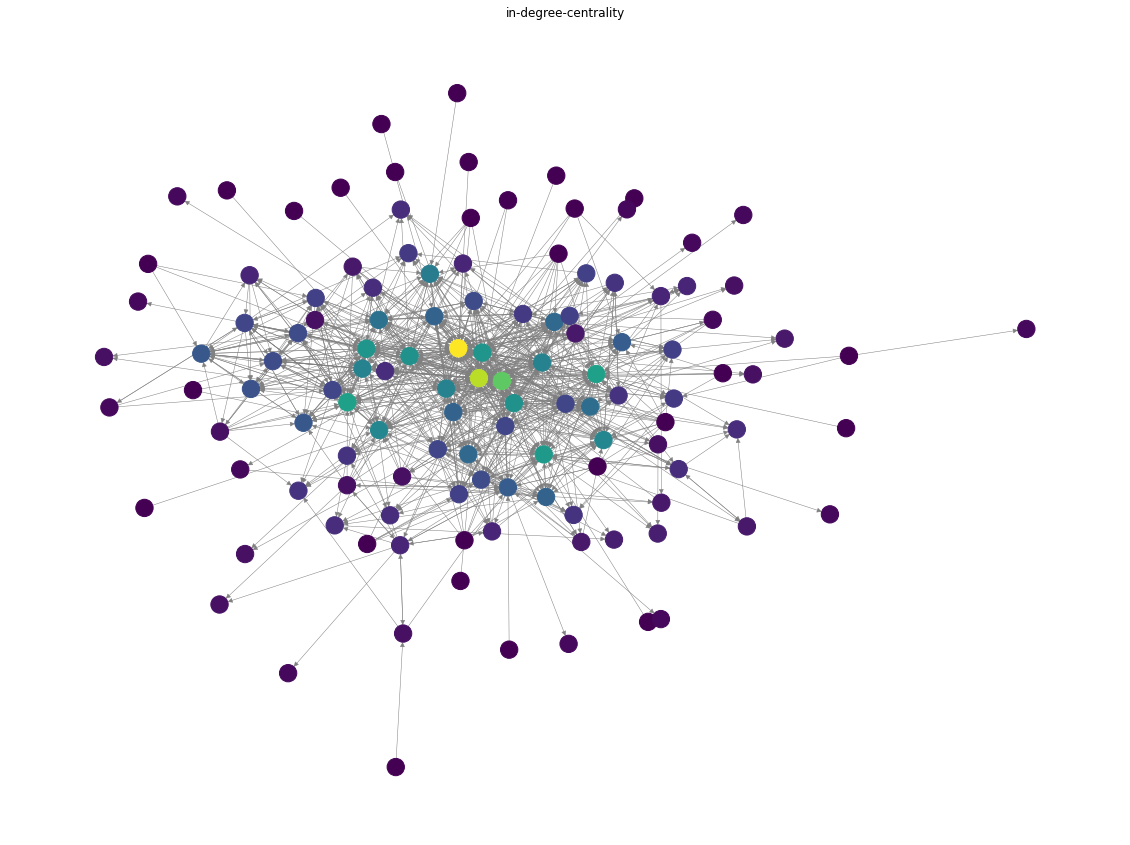

In [83]:
nodecolors = list(nx.in_degree_centrality(G).values())
#colors = edgecolors

#nodecolors = most_active_channel_subgraph
options = {
    #"edge_cmap": 'grey',
    "node_color": nodecolors,
    "edge_color": 'grey',
    "width": 0.5,
    #"node_size": 20,
    #"edge_cmap": 'RdBu_r',
    "with_labels": False, 

}
plt.figure(figsize = (20,15))
plt.title('in-degree-centrality')
nx.draw(G, pos, **options)
plt.show()

In [97]:
plt.scatter(, cmap = list(nx.betweenness_centrality(G, normalized=True).values()))

[0.037253767575118335,
 0.0,
 0.0058545618022742205,
 0.008400045599119674,
 0.0,
 0.0,
 0.08740763634009822,
 0.02622930224782077,
 0.05573020772094846,
 0.01629368059923615,
 0.0,
 0.4471393223394858,
 0.0,
 0.021756661246040327,
 0.0,
 0.05339285714285714,
 0.005730697628845779,
 0.033252464170220146,
 0.0,
 0.13262851567862458,
 0.0,
 0.0,
 0.03235596707818929,
 0.0,
 0.003888888888888889,
 0.0,
 0.10651109909416011,
 0.026493484224965707,
 0.03892270422226848,
 0.0,
 0.024691358024691357,
 0.034229129923574374,
 0.024691358024691357,
 0.08983018010795787,
 0.05610739080374157,
 0.08200404558928523,
 0.013104791299235748,
 0.04498279296754242,
 0.0,
 0.0,
 0.015145012737605332,
 0.002077680549902772,
 0.024691358024691357,
 0.0,
 0.0015123456790123457,
 0.0,
 0.0259823989453619,
 0.209552053338818,
 0.024053749748194193,
 0.0,
 0.0,
 0.05758515847704302,
 0.02492283950617284,
 0.0,
 0.0,
 0.0,
 0.0,
 0.061259686815242395,
 0.0,
 0.0,
 0.0,
 0.03764330748127045,
 0.00138888888888888

In [93]:
[nx.edge_betweenness_centrality(maxcc).values()]

[dict_values([0.0, 0.01094062738013001, 0.018225807655373526, 0.023595345814911153, 0.024390243902439025, 0.019928497344938182, 0.0, 0.018014271853476913, 0.006375972048962114, 0.0, 0.022821024242460023, 0.012992754883928698, 0.0, 0.019887990326111375, 0.00943535035675957, 0.011457236095899149, 0.0, 0.024390243902439025, 0.0, 0.024390243902439025, 0.0, 0.013574916373949265, 0.017237287493411625, 0.015985814179129445, 0.011548887472156506, 0.021012048609157914, 0.04159784058158041, 0.024390243902439025, 0.025204446929830857, 0.024390243902439025, 0.0, 0.010310237455675577, 0.009974644279070658, 0.01367566489517709, 0.017876120834567088, 0.02373270277515987, 0.0, 0.016626223988464292, 0.01772041903026547, 0.028582862819538504, 0.0041625442709453545, 0.019738269693102578, 0.02191154892148569, 0.024390243902439025, 0.0, 0.0068082123637679196, 0.01253655174161046, 0.013103403505390857, 0.002559470039144836, 0.021175153763229638, 0.024390243902439025, 0.0, 0.022302465253737913, 0.08337749380

In [18]:
np.dot(dir_nw, dir_nw)

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  1,  0,  0],
       ...,
       [ 0,  0,  1, ..., 17,  1,  0],
       [ 0,  0,  0, ...,  1,  6,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

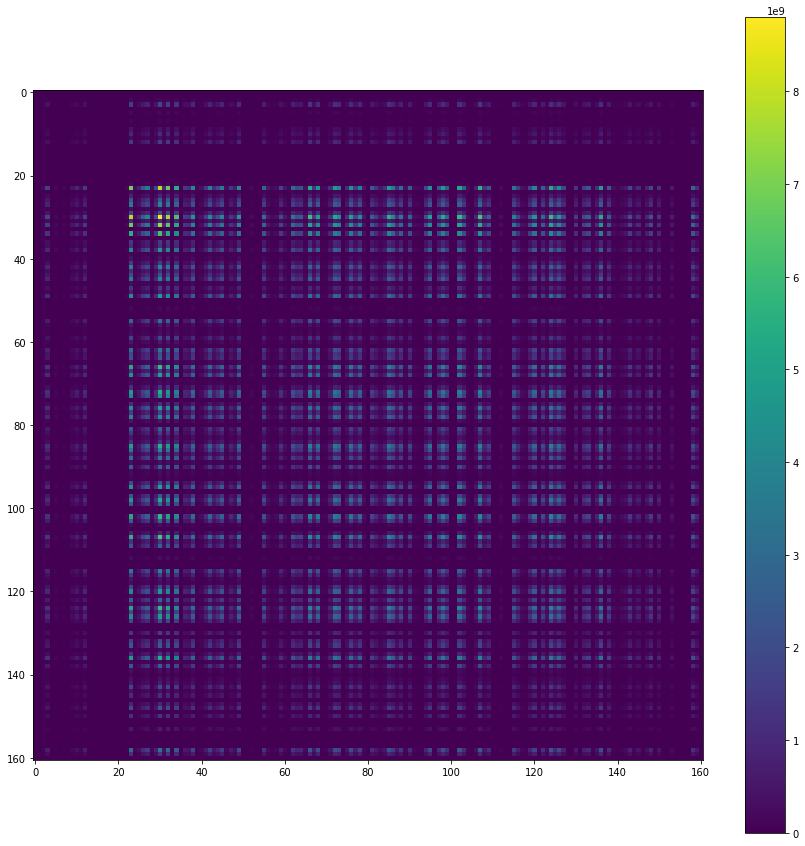

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(np.dot(np.dot(first_degree_paths, first_degree_paths), np.dot(first_degree_paths, first_degree_paths)))
plt.colorbar()

In [211]:
np.where(np.dot(dir_nw, dir_nw)==65)

(array([30]), array([30]))

In [20]:
first_degree_paths = np.dot(dir_nw, dir_nw)
np.argsort(first_degree_paths[30])[::-1][1]

23

In [ ]:
G = nx.from_numpy_array(, create_using = nx.DiGraph)

In [59]:
cliques = list(nx.enumerate_all_cliques(G))[::-1]

In [136]:
network = make_reaction_network(reaction_data, users)
nw_tmp = np.sum(network['nw'], axis = 2)
#nw = nx.DiGraph(nw_tmp)


dir_nw = np.sign(np.transpose(nw_tmp) + nw_tmp)
G=nx.from_numpy_matrix(dir_nw)
first_degree_paths = np.dot(dir_nw, dir_nw)



max_influencer = np.where(first_degree_paths == np.max(first_degree_paths))[0][0]

cliques = list(nx.enumerate_all_cliques(G))[::-1]

cliques_with_max_influencer_indx = [i for i in range(len(cliques)) if max_influencer in cliques[i]]
connections_max_influencer = np.nonzero(dir_nw[max_influencer])[0]

cliques_with_max_influencer = [cliques[i] for i in cliques_with_max_influencer_indx]

#### idea: plot nodes that are in many cliques together next to each other!
#### go through all the nodes that are one degree from node 0 and put them into cliques!

#### start with clique 0 
### make a matrix of how many cliques the nodes in ego network from 0 are next to each other

clique_matrix = np.zeros((len(connections_max_influencer), len(connections_max_influencer)), dtype = int)
for j in range(len(connections_max_influencer)):
    for k in range(len(connections_max_influencer)):
        a = sum([1 for i in range(len(cliques)) if connections_max_influencer[j] in cliques[i] and connections_max_influencer[k] in cliques[i] and j != i])
        clique_matrix[j, k] = a

for i in range(len(connections_max_influencer)):
    clique_matrix[i][i] = 0



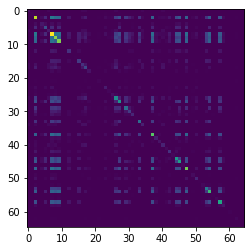

In [135]:
plt.imshow(clique_matrix)

True

In [ ]:
sum([i for i in range(len(cliques)) if j in cliques[i] and k in cliques[i]])

In [122]:
cliques_with_max_influencer = [cliques[i] for i in cliques_with_max_influencer_indx]

In [123]:
cliques_with_max_influencer

[[23, 30, 32, 34, 85, 98, 102, 107, 120, 124, 136],
 [23, 30, 32, 34, 78, 85, 98, 102, 107, 120, 124],
 [23, 30, 32, 34, 68, 85, 98, 102, 107, 124, 136],
 [23, 30, 32, 34, 68, 78, 85, 98, 102, 107, 124],
 [23, 30, 32, 34, 68, 72, 85, 102, 107, 124, 136],
 [23, 30, 32, 34, 66, 68, 72, 85, 107, 124, 136],
 [23, 27, 30, 34, 68, 85, 98, 102, 107, 124, 136],
 [23, 27, 30, 34, 68, 78, 85, 98, 102, 107, 124],
 [30, 32, 34, 85, 98, 102, 107, 120, 124, 136],
 [30, 32, 34, 78, 85, 98, 102, 107, 120, 124],
 [30, 32, 34, 68, 85, 98, 102, 107, 124, 136],
 [30, 32, 34, 68, 78, 85, 98, 102, 107, 124],
 [30, 32, 34, 68, 72, 85, 102, 107, 124, 136],
 [30, 32, 34, 66, 68, 72, 85, 107, 124, 136],
 [30, 32, 34, 42, 85, 98, 107, 120, 124, 136],
 [30, 32, 34, 42, 78, 85, 98, 107, 120, 124],
 [30, 32, 34, 42, 66, 85, 107, 120, 124, 136],
 [30, 32, 34, 42, 66, 78, 85, 107, 120, 124],
 [27, 30, 34, 68, 85, 98, 102, 107, 124, 136],
 [27, 30, 34, 68, 78, 85, 98, 102, 107, 124],
 [23, 30, 34, 85, 98, 102, 107, 12

In [97]:
max_influencer = np.where(first_degree_paths == np.max(first_degree_paths))[0][0]

30

In [96]:
np.where(dir_nw == np.max(dir_nw))[0][0]

2

In [83]:
largest_clique = G.subgraph(a)

In [79]:
G

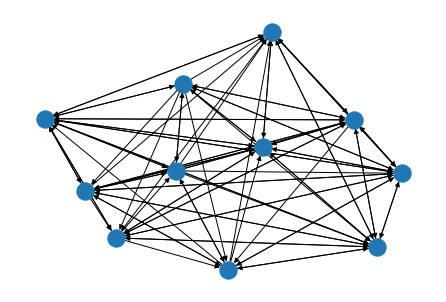

In [84]:
nx.draw(largest_clique, arrows=True)

In [53]:
#### plot based on cliques
r = 2
first_degree_paths = np.dot(dir_nw, dir_nw)
np.argsort(first_degree_paths[30])[::-1][1]
pos = {}
i = 0
for j in list(nx.enumerate_all_cliques(G))[::-1]:

    u = len(j)
    #m = i + r
    for k in range(len(j)):
        if not j[k] in pos:
            x = np.sin(u/360 + k)*r 
            y = np.cos(u/360 + k)*r 
            pos[j[k]] = (x, y)


    i = i +1



In [54]:
i

24003

NetworkXError: Node 0 has no position.

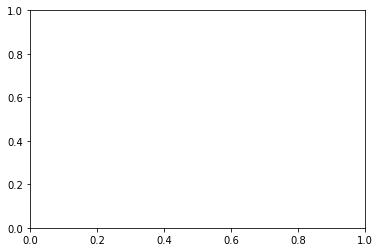

In [51]:
nx.draw_networkx_nodes(G, pos, node_size = 10)

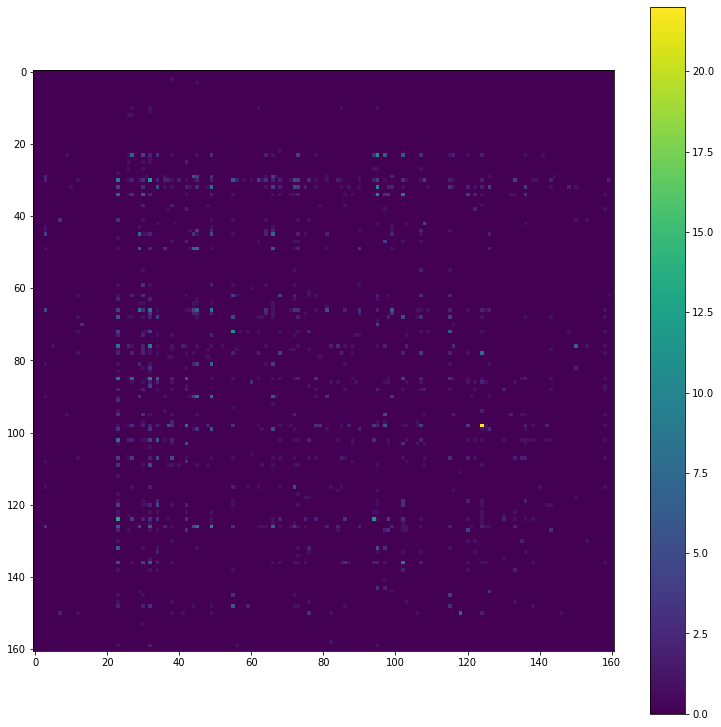

In [206]:
plt.figure(figsize=(13,13))
plt.imshow(nw_tmp)
plt.colorbar()

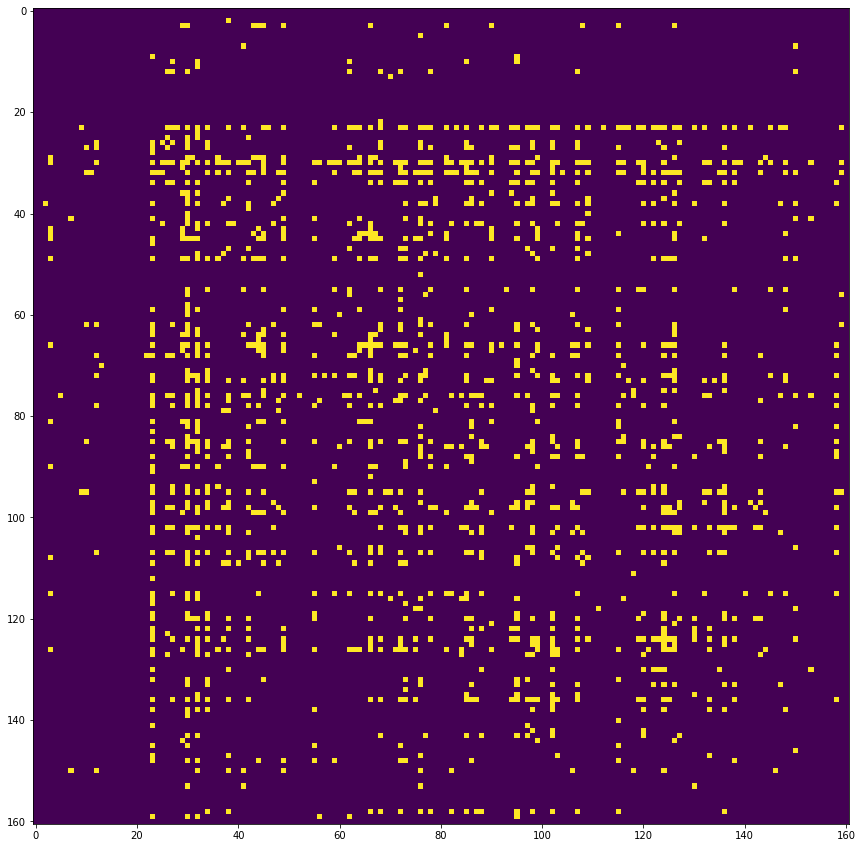

In [194]:
plt.figure(figsize=(15,15))
plt.imshow(dir_nw)

In [188]:
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([[10, 11, 12], [13, 14, 15]])

In [189]:
a + b

array([[11, 13, 15],
       [17, 19, 21]])

In [184]:
np.sum(nw_tmp)

1902

In [ ]:
n

In [36]:
np.argsort(np.sum(dir_nw, axis =0))[::-1]

array([ 30,  23,  32, 102,  76,  66, 107, 124,  34,  95,  98, 126,  72,
        85, 136,  49,  38,  68,  73,  45,  86,  42, 120, 115,  78,  55,
        62,  27,  88,  90,  99,  44, 158,  97, 103,  81,  29, 122, 109,
        26,  64, 133, 127,   3, 148, 138, 150, 143, 125,  67, 130,  59,
        94,  63,  41,  77, 132, 119,  12, 116,  37,  36, 108,  82,  47,
        43, 106,  75,  84,  87, 159,  31, 135,  48,  71, 145,  79, 147,
        10, 118,  25, 153, 123,  56,  60,  70, 142, 144,  65, 121,   7,
        83, 141,   9,  40, 117,  89,  22,  24,  46,  28,  52,  39,  93,
        57, 104,   2,   5, 146, 140, 139, 137, 134,  11, 112, 111,  58,
        13,  69,  61,  92,  91,   1,  19,   4,  20,   6,  14,  21,  15,
        18,   8,  17,  16, 160,  80,  33, 114, 157, 156, 155, 154, 152,
       151, 149, 131, 129, 128, 113,  35, 110, 105, 101, 100,  96,  74,
        54,  53,  51,  50,   0])

In [185]:
np.sum(np.sign(np.sum(np.sum(network['nw'], axis = 2), axis = 1)))

98

In [109]:
users_data = pd.DataFrame(users, columns=['user id'])

#### add network measurements to user data frame

list_of_methods = ['in_degree_centrality', 'out_degree_centrality', 'eigenvector_centrality', 'betweenness_centrality', 'clustering']

for i in list_of_methods:
    method_to_call = getattr(nx, i)
    result = method_to_call(nw)
    users_data[i] = pd.Series(result)

    
#### add stats to user data frame



#users_data["in_degree_centrality"] = pd.Series(nx.in_degree_centrality(nw))

In [122]:
### create pos for plotting based on clustering (weeeeelllll, let's at least try it)

centrality = users_data['in_degree_centrality'] + users_data['out_degree_centrality']
#clustering = users_data['clustering']

np.argmax(centrality)

30

In [156]:
first_node = np.argmax(centrality)
first_node_nw = nx.single_source_shortest_path_length(maxcc, first_node)

first_degree_nw = [key for (key, value) in first_node_nw.items() if value == 1]

#component1 = 

### make a matrix of first degree networks for all of them 

for i in first_degree_nw:
    
    
    node_nw = nx.single_source_shortest_path_length(maxcc, i)
    cluster1 = [m for m in node_nw if m in first_degree_nw]
    
    for j in cluster1:
        
    
    



In [157]:
cluster1

[124,
 133,
 138,
 23,
 27,
 32,
 34,
 37,
 42,
 49,
 66,
 68,
 78,
 94,
 95,
 102,
 107,
 3,
 12,
 26,
 29,
 36,
 38,
 40,
 45,
 55,
 56,
 58,
 60,
 62,
 63,
 64,
 71,
 72,
 73,
 76,
 81,
 84,
 85,
 90,
 97,
 103,
 108,
 115,
 116,
 139,
 143,
 159]

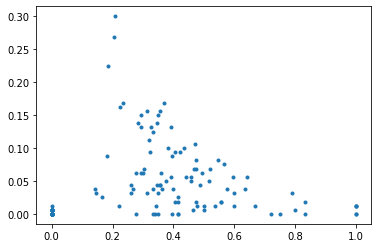

In [114]:
plt.plot(users_data['clustering'], users_data['in_degree_centrality'], '.')

In [110]:
users_data

,user id,in_degree_centrality,out_degree_centrality,eigenvector_centrality,betweenness_centrality,clustering
0,U01026MQ4Q4,0.0000,0.00000,6.121652e-15,0.000000,0.000000
1,U0103R93TJR,0.0000,0.00000,6.121652e-15,0.000000,0.000000
2,U01046P5G6M,0.0000,0.00625,6.121652e-15,0.000000,0.000000
3,U0104S7DUJ2,0.0750,0.00625,1.028552e-01,0.000334,0.564935
4,U010868USDS,0.0000,0.00000,6.121652e-15,0.000000,0.000000
...,...,...,...,...,...,...
156,UTUB7AF1B,0.0000,0.00000,6.121652e-15,0.000000,0.000000
157,UTW6MAKEK,0.0000,0.00000,6.121652e-15,0.000000,0.000000
158,UUSDRHV50,0.1000,0.00625,1.433149e-01,0.001127,0.382353
159,UUTTYR6LE,0.0125,0.02500,2.199625e-02,0.000013,0.600000


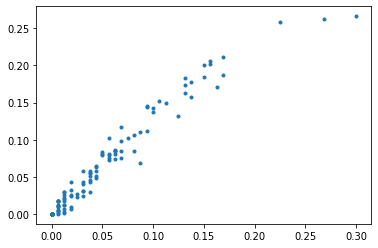

In [108]:
plt.plot(users_data['in_degree_centrality'], users_data['eigenvector_centrality'], '.')

In [96]:
method_to_call = getattr(nx, 'in_degree_centrality')
result = method_to_call(nw)



In [97]:
result

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.07500000000000001,
 4: 0.0,
 5: 0.00625,
 6: 0.0,
 7: 0.0125,
 8: 0.0,
 9: 0.0125,
 10: 0.00625,
 11: 0.0,
 12: 0.043750000000000004,
 13: 0.00625,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.30000000000000004,
 24: 0.0,
 25: 0.0,
 26: 0.08750000000000001,
 27: 0.10625000000000001,
 28: 0.0,
 29: 0.0625,
 30: 0.225,
 31: 0.037500000000000006,
 32: 0.26875,
 33: 0.0,
 34: 0.15000000000000002,
 35: 0.0,
 36: 0.05,
 37: 0.037500000000000006,
 38: 0.1625,
 39: 0.00625,
 40: 0.0125,
 41: 0.0125,
 42: 0.1375,
 43: 0.03125,
 44: 0.08125,
 45: 0.13125,
 46: 0.0,
 47: 0.0,
 48: 0.037500000000000006,
 49: 0.16875,
 50: 0.0,
 51: 0.0,
 52: 0.00625,
 53: 0.0,
 54: 0.0,
 55: 0.125,
 56: 0.025,
 57: 0.00625,
 58: 0.00625,
 59: 0.018750000000000003,
 60: 0.025,
 61: 0.0,
 62: 0.0625,
 63: 0.03125,
 64: 0.08125,
 65: 0.0,
 66: 0.15625,
 67: 0.0125,
 68: 0.09375,
 69: 0.0,
 70: 0.0,
 71: 0.037500000000000006,
 72: 0.1

In [80]:
users_data['in-degree-centrality'].map(nx.in_degree_centrality(nw))
#users_data['out-degree-centrality']= users_data['out-degree-centrality'].map(nx.out_degree_centrality(nw))
#users_data['bla']= users_data['index'].map(nx.in_degree_centrality(nw))


#users_data['in-degree-centrality'] = nx.in_degree_centrality(nw)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
156   NaN
157   NaN
158   NaN
159   NaN
160   NaN
Name: in-degree-centrality, Length: 161, dtype: float64

In [92]:
users_data

,user id,in_degree_centrality
0,U01026MQ4Q4,0.0000
1,U0103R93TJR,0.0000
2,U01046P5G6M,0.0000
3,U0104S7DUJ2,0.0750
4,U010868USDS,0.0000
...,...,...
156,UTUB7AF1B,0.0000
157,UTW6MAKEK,0.0000
158,UUSDRHV50,0.1000
159,UUTTYR6LE,0.0125


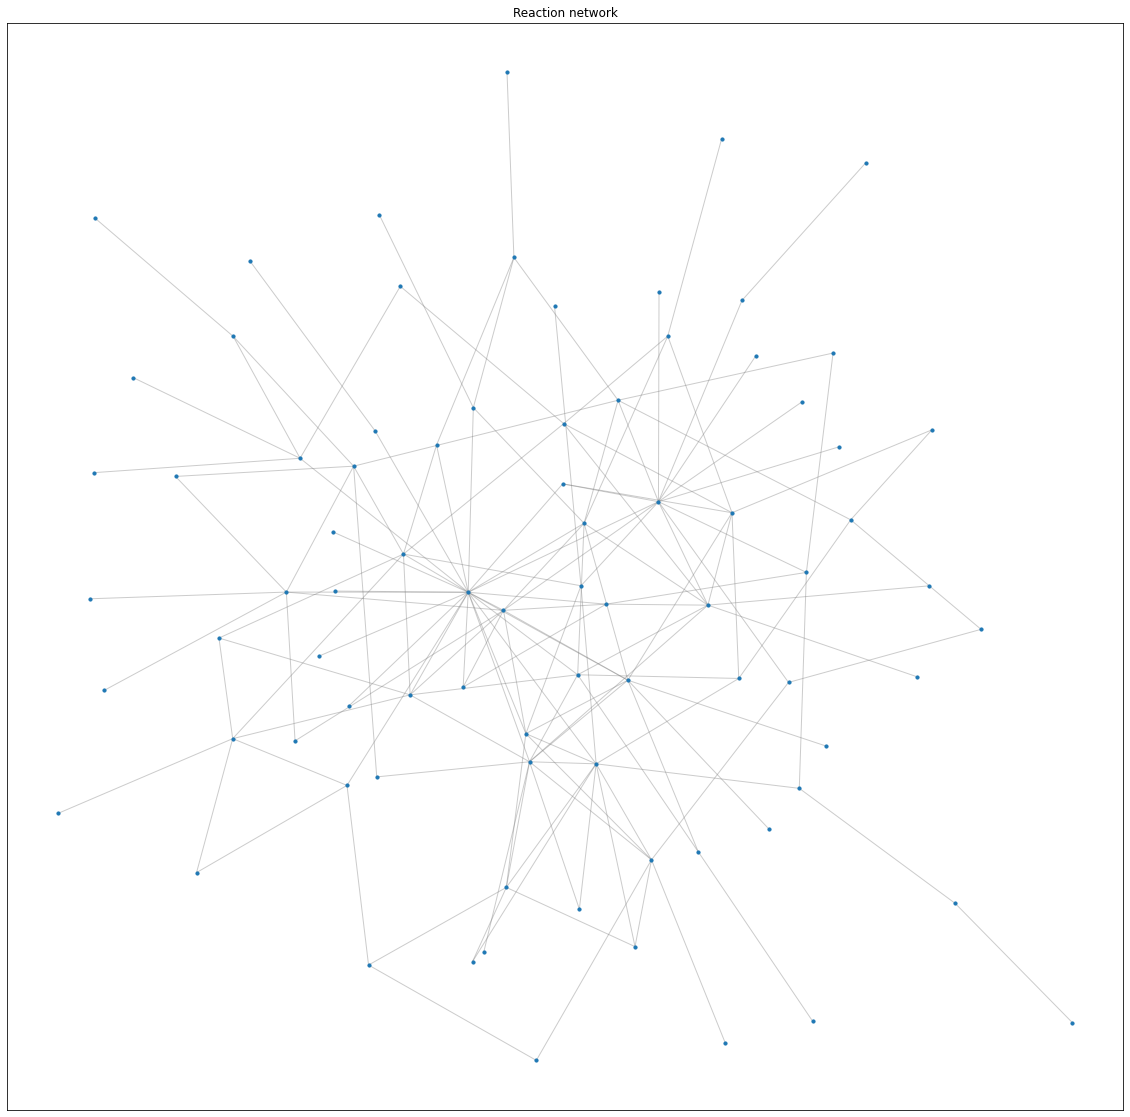

In [42]:
pos = nx.nx_pydot.graphviz_layout(maxcc)
plt.figure(figsize = (20,20))
plt.title('Reaction network')
nx.draw_networkx_nodes(maxcc, pos, node_size = 10)
nx.draw_networkx_edges(maxcc, pos, edge_color ='grey', alpha = 0.4, arrows = True)
plt.show()

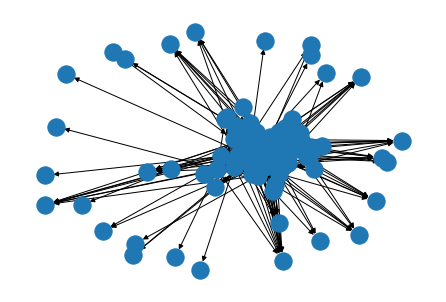

KeyError: 1

In [28]:
G = maxcc

nx.draw_spring(G)
py.show()


fixedpos = {1:(0,0), 6:(1,1), 11:(1,0), 16:(0,1)}
pos = nx.spring_layout(G, fixed = fixedpos.keys(), pos = fixedpos)

nx.draw_networkx(G, pos=pos)

py.show()

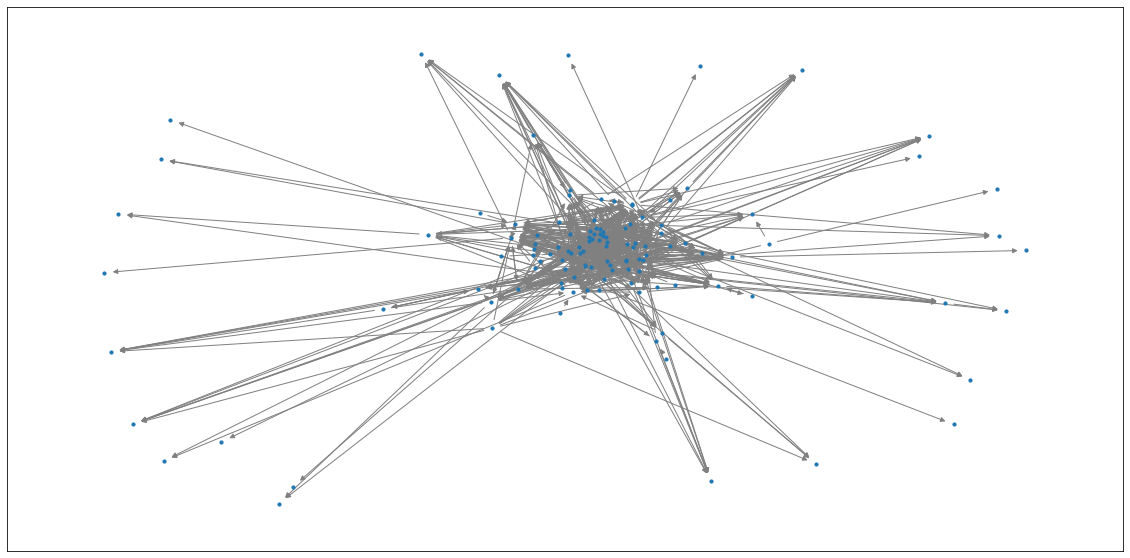

In [57]:
G = maxcc

plt.figure(figsize=(20,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       #node_color = values, 
                       node_size = 10)
#nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='grey', arrows=True)
#nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()

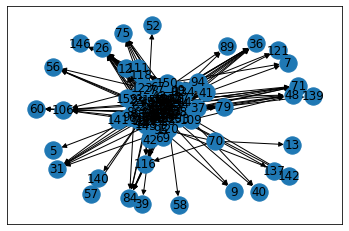

In [59]:
nx.draw_networkx(G)

AttributeError: 'DiGraph' object has no attribute 'is_weighted'

In [25]:
nw.edges()

OutEdgeView([(2, 38), (3, 45), (10, 27), (10, 32), (10, 62), (10, 85), (10, 95), (11, 32), (12, 26), (12, 27), (22, 68), (23, 9), (23, 26), (23, 27), (23, 30), (23, 32), (23, 34), (23, 38), (23, 45), (23, 49), (23, 64), (23, 66), (23, 73), (23, 78), (23, 94), (23, 95), (23, 97), (23, 102), (23, 107), (23, 115), (23, 116), (23, 120), (23, 124), (23, 136), (23, 141), (24, 32), (25, 26), (25, 30), (25, 32), (25, 42), (27, 26), (27, 30), (27, 94), (27, 95), (27, 107), (28, 23), (29, 3), (29, 31), (29, 36), (29, 44), (29, 45), (29, 49), (29, 64), (29, 66), (29, 67), (29, 81), (29, 90), (29, 99), (29, 126), (29, 144), (30, 3), (30, 12), (30, 23), (30, 26), (30, 27), (30, 29), (30, 30), (30, 32), (30, 34), (30, 36), (30, 37), (30, 38), (30, 40), (30, 42), (30, 45), (30, 49), (30, 55), (30, 56), (30, 58), (30, 60), (30, 62), (30, 63), (30, 64), (30, 66), (30, 68), (30, 71), (30, 72), (30, 73), (30, 76), (30, 78), (30, 81), (30, 84), (30, 85), (30, 90), (30, 94), (30, 95), (30, 97), (30, 102), 

In [159]:
total_network =  networks[0] + networks[1] ### ok problem: not the same size! use absolute channellist!

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


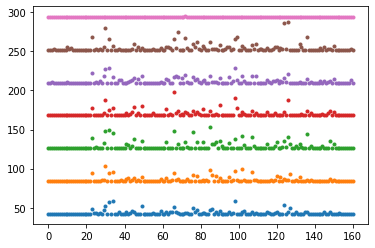

In [198]:
### make a function (?) for plots so that one can chose channel, usw.! axis blabla
### sort channels with something! (häufigkeit totale interactions?)

plt.plot( (np.sum(np.sum(month_reaction, axis = 0), axis = 1)), '.')

In [173]:
np.shape(np.sum(np.sum(total_network, axis = 0), axis=1))

(42,)

In [196]:
month_reaction = make_time_network(reaction_data, users, channels, 'month')

In [151]:
make_channel_network(reaction_data, users)

{'nw': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 

In [ ]:
total_channel_networks = 

In [422]:
weeks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [339]:
abs_ts = np.sort(np.unique(np.concatenate((ts1, ts2, ts3))))

In [437]:
### make weekly timescale ### add something 

def make_time_network(data, users, timescale):
    network, ts = make_channel_network(data, users)
    
    if timescale == 'week': 
        time_ts = [i.isocalendar()[1] for i in ts]
    else:
        time_ts = [i.month for i in ts]

    u, indices = np.unique(time_ts, return_inverse=True)
    ### sum up the network based on the number in weekly_ts!
    time_network = np.zeros((np.shape(network)[0], np.shape(network)[1], len(u)))

  
    for i in list(range(len(u))):
        indx = np.nonzero(i == indices)[0]
        new_network = np.sum(network[:, :, indx], axis = 2)
        time_network[:, :, i] = new_network
        #weekly_network = np.stack(weekly_network, new_network)

    return time_network, u

Text(0.5, 1.0, 'Monthly posts')

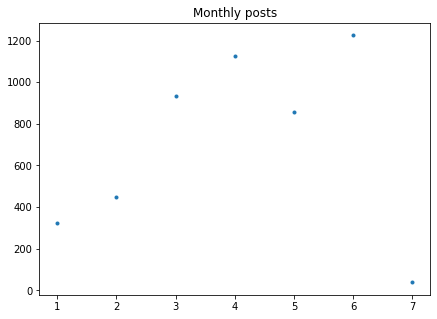

In [441]:
monthly_network, months = make_time_network(data, users, 'month')
plt.figure(figsize=(7,5))
plt.plot(months, (np.sum(np.sum(monthly_network, axis = 1), axis = 0)), '.')
plt.title('Monthly posts')

In [445]:
months = ['January', 'February', 'March', 'April']

TypeError: function missing required argument 'day' (pos 3)

In [436]:
np.shape(monthly_network)

(161, 42, 7)

In [394]:
np.shape(network)

(161, 42, 181)

In [374]:
u, indices = np.unique(weekly_ts, return_inverse=True)

In [379]:
indx = np.nonzero(i == indices)

In [382]:
indx[0][0]

3

Text(0.5, 1.0, 'Weekly react ')

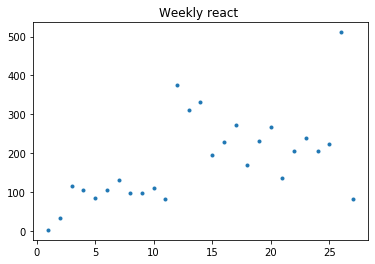

In [427]:
plt.plot(weeks, (np.sum(np.sum(weekly_network, axis = 1), axis = 0)), '.')
plt.title('Weekly react ')

In [291]:
np.where(channels=='beer-therapy')

(array([6]),)

In [ ]:
np.shape()

In [266]:
### make weekly or monthly reactions! list?



In [226]:
reaction_network = make_reaction_network(reaction_data, users)
thread_network = make_reaction_network(threads_data, users)
posts_network = make_channel_network(data, users)

### ok wait we can do all this in a channel as well...??????

In [253]:
np.shape(_network)

(161, 42, 181)

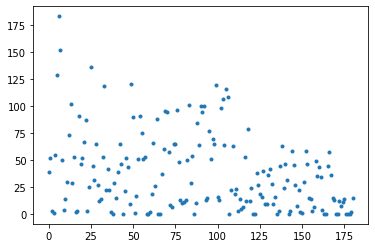

In [255]:
plt.plot(((np.sum(np.sum(reaction_network, axis = 1), axis = 0)) + np.sum(np.sum(posts_network, axis = 1), axis = 0)), '.')

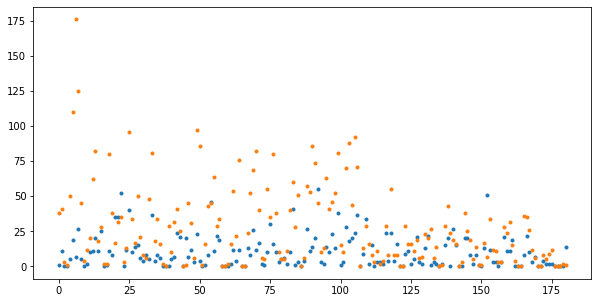

In [263]:
plt.figure(figsize = (10,5))
plt.plot(np.sum(np.sum(reaction_network, axis = 1), axis = 0), '.')
plt.plot(np.sum(np.sum(posts_network, axis = 1), axis = 0), '.')
#plt.xaxis('time')

In [229]:
np.shape(posts_network)

(161, 42, 181)

In [44]:
### analyse posts in channels
### Make a person - channel network: how much a persons posts in every channel (contains information about how many posts in total as well)
### how to make a timeline? make a 3 dim matrix? ok let's do it! for every month? for every day?!!!
### extract wheter it is a comment or not!

### just posts and no replies!

## make network of people and channels

original_posts = data[data['parent_user_id'].isnull()]

posts_network = np.zeros((len(users), len(channels)), dtype = int)

for k in range(len(original_posts)):
    user = original_posts.iloc[k]['user']
    channel = original_posts.iloc[k]['channel']
    
    i = np.where(users == user)[0][0]
    j = np.where(channel == channels)[0][0]
    
    posts_network[i, j] = posts_network[i, j] + 1


### ok in the end just add the replies to it!


In [45]:
tot_posts_channel = np.sum(posts_network, axis = 0)
tot_posts_users = np.sum(posts_network, axis = 1)

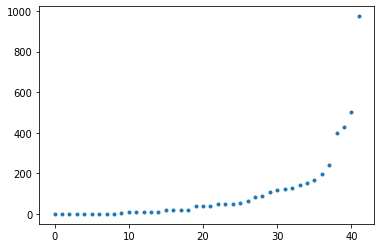

In [46]:
plt.plot(np.sort(tot_posts_channel), '.')

In [47]:
channels[list(np.array(np.where(tot_posts_channel > 100)[0], dtype = int))]

array(['axiondm-wp1', 'beer-therapy', 'gaia', 'gbt-axion-seti', 'general',
       'okc-axions', 'okc-cg', 'okc-fika', 'random', 'snova',
       'sugalaxygroup', 'supernova6', 'ztf-borg'], dtype=object)

In [167]:
threads_data = data[~data['parent_user_id'].isnull()]
posts_with_reactions_id = np.unique(threads_data['thread_ts'])

threads_data = threads_data.sort_values('thread_ts')
threads_data = threads_data.rename({'parent_user_id': 'original_user'}, axis = 'columns')

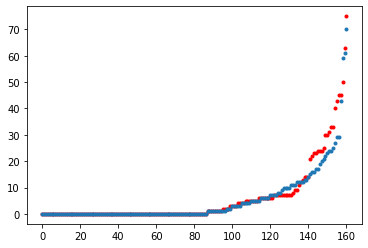

In [151]:
plt.plot(np.sort(np.sum(reaction_network[:, :, 1], axis = 1)), '.', c='r')
plt.plot(np.sort(np.sum(reaction_network[:, :, 0], axis = 1)), '.')

In [ ]:
### more intersting: how do the channels change?

In [91]:
### Make a matrix with measurements about each user. 

user_data = pd.DataFrame(index = range(len(users)), columns = ['id', 'original posts', 'replies to posts', 'replies other users',
                                                              'n of reactions from other users', 'n of reactions'])
user_data['id'] = users

original_posts = np.sum(posts_network, axis = 1)
user_data['original posts'] = original_posts

n_posts_thread = np.sum(threads_network, axis = 1)
user_data['replies to posts'] = n_posts_thread

n_replies_total = np.sum(threads_network, axis = 0)
user_data['replies other users'] = n_replies_total

n_reactions = np.sum(reaction_network, axis = 0)
user_data['n of reactions from other users'] = n_reactions

n_reacting = np.sum(reaction_network, axis = 1)
user_data['n of reactions'] = n_reacting

In [92]:
user_data

,id,original posts,replies to posts,replies other users,n of reactions from other users,n of reactions
0,U01026MQ4Q4,5,0,0,0,0
1,U0103R93TJR,4,0,0,0,0
2,U01046P5G6M,5,0,0,1,0
3,U0104S7DUJ2,60,11,7,1,23
4,U010868USDS,1,0,0,0,0
5,U010DAWCE90,5,25,13,0,1
6,U010UCSK25B,4,0,0,0,0
7,U0115LXTCBZ,4,0,0,0,5
8,U01189DAVE2,7,2,2,0,0
9,U011CRVUK29,5,0,0,0,2
